In [3]:
import pandas as pd
import scipy.stats
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import io

In [4]:
# from google.colab import files
# uploaded = files.upload()

In [5]:
filename = "UCLA_Microsoft_Data.xlsx"

ContosoRevData = pd.read_excel(filename, sheet_name=1)
FortuneGlobal2000 = pd.read_excel(filename, sheet_name=2)
TAM = pd.read_excel(filename, sheet_name=3)


## **0.Necessary Feature Engineering**

1. Adding Geo & Category market share

In [6]:
# Step 0: Filter for TAM data of Product A to E (exclude RevX)
product_tam = TAM[TAM['Metric_Name'].str.contains("Proj_TAM_Prod")].copy()

# Step 1: Aggregate TAM by Geo_Entity and Commercial_Category
geo_tam = product_tam[product_tam['Attr_Name'] == 'Geo_Entity'] \
    .groupby('Attr_Value')['Metric_Value'].sum().reset_index() \
    .rename(columns={'Attr_Value': 'Geo_Entity', 'Metric_Value': 'Geo_TAM_FY30'})

cat_tam = product_tam[product_tam['Attr_Name'] == 'Commercial_Category'] \
    .groupby('Attr_Value')['Metric_Value'].sum().reset_index() \
    .rename(columns={'Attr_Value': 'Commercial_Category', 'Metric_Value': 'Category_TAM_FY30'})

# Step 2: Merge aggregated TAM into ContosoRevData
ContosoRevData = ContosoRevData.merge(geo_tam, on='Geo_Entity', how='left')
ContosoRevData = ContosoRevData.merge(cat_tam, on='Commercial_Category', how='left')

# Step 3: Calculate FY30 Market Share
ContosoRevData['MarketShare_FY30_Geo'] = ContosoRevData['PotentialRevenue_FY30'] / ContosoRevData['Geo_TAM_FY30']
ContosoRevData['MarketShare_FY30_Category'] = ContosoRevData['PotentialRevenue_FY30'] / ContosoRevData['Category_TAM_FY30']



2. Adding FY22-26 revenue growth CAGR

In [7]:
ContosoRevData['Revenue_CAGR'] = (
    (ContosoRevData['TotalRevenue_FY26'] / ContosoRevData['TotalRevenue_FY22']) ** (1 / 4) - 1) * 100

3. Adding FY26 to FY30 revenue potential

In [8]:
ContosoRevData['Revenue_potential'] = ContosoRevData['PotentialRevenue_FY30'] - ContosoRevData['TotalRevenue_FY26']

In [9]:
ContosoRevData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         50000 non-null  int64  
 1   Geo_Entity                 50000 non-null  object 
 2   Area_National              50000 non-null  object 
 3   Area_Admin                 19100 non-null  object 
 4   Area_Urban                 50000 non-null  object 
 5   Commercial_Category        50000 non-null  object 
 6   Commercial_Stream          50000 non-null  object 
 7   Commercial_Specialty       50000 non-null  object 
 8   MarketDomain               50000 non-null  object 
 9   MarketTier_FY26            50000 non-null  object 
 10  MarketTier_FY25            50000 non-null  object 
 11  MarketTier_FY24            50000 non-null  object 
 12  MarketTier_FY23            50000 non-null  object 
 13  MarketTier_FY22            50000 non-null  obj

In [10]:
# ===============================
# Define numeric columns for modeling
# ===============================
num_cols = [
    'MarketShare_FY30_Geo',
    'MarketShare_FY30_Category',
    'Revenue_CAGR',        # correct name
    'Revenue_potential',
    'TotalRevenue_FY26',   # revenue scale
]

# sanity check
ContosoRevData[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
MarketShare_FY30_Geo,50000.0,2.363855e-04,1.100268e-03,1.351147e-07,1.130556e-05,3.797320e-05,1.323854e-04,6.783354e-02
MarketShare_FY30_Category,50000.0,9.011924e-05,4.803102e-04,2.785719e-07,9.076416e-06,2.180523e-05,6.183529e-05,5.943392e-02
Revenue_CAGR,50000.0,2.428915e+01,1.647239e+01,-2.564810e+01,1.287989e+01,2.261442e+01,3.396608e+01,1.340934e+02
Revenue_potential,50000.0,2.601303e+07,9.678146e+07,3.429300e+04,3.123951e+06,7.147706e+06,1.933162e+07,7.210167e+09
TotalRevenue_FY26,50000.0,9.807864e+06,3.422571e+07,8.774100e+04,1.164813e+06,2.484595e+06,6.787751e+06,1.604218e+09


## **1. Modeling Setup**

#### 1.0 Set Seed
We set a random seed at the start of the modeling section to ensure reproducibility.
Although Ward clustering itself is deterministic, other steps like PCA, K-Means initialization, or data sampling involve randomness. Fixing a seed makes sure that results (cluster assignments, KPIs, and visuals) remain consistent every time the notebook is re-run.

In [11]:
import numpy as np, random
np.random.seed(42)
random.seed(42)

### **1.1 KPI set up (Encapsulated)**

#### **1.1.0 Tier Policy**

Let us carry no assumptions about tier “A/B/C/D”. Instead, carry a tier policy that can map an integer cluster id → ordered business tiers for any K.

We introduce a **Tier Policy framework** to make KPI calculation flexible across different numbers of clusters (K).

Instead of hard-coding four tiers (A–D) and treating A+B as strategic, the Tier Policy dynamically maps cluster groups into ordered tiers (Tier A, B, C, ...) based on their performance indicators (e.g., average PI or Revenue).
This allows the same KPI formulas to apply seamlessly whether the model generates 3, 4, or 5 tiers—keeping comparisons consistent and scalable for future tuning.

##### **1.1.0.1 policy v1: mean PI weighted ranking**


In [12]:
from dataclasses import dataclass
from typing import Callable, Dict, Any, List
import numpy as np
import pandas as pd
import json
from scipy.stats import spearmanr


@dataclass
class TierPolicy:
    # Given a dataframe with columns [cluster_col, pi_col, rev_col],
    # return a mapping: cluster_id -> tier_label (ordered high→low)
    # e.g., rank clusters by mean PI or RevPotential, then name Tier A..N
    rank_key: Callable[[pd.DataFrame, str, str, str], pd.Series]
    make_labels: Callable[[int], List[str]]

def default_rank_key(df, cluster_col, pi_col, rev_col):
    # Example: rank clusters by mean PI (fallback to revenue)
    grp = df.groupby(cluster_col).agg({pi_col:'mean', rev_col:'mean'})
    score = 0.7*grp[pi_col].rank(ascending=False, method='dense') \
          + 0.3*grp[rev_col].rank(ascending=False, method='dense')
    # lower rank value = better; convert to descending score:
    return -score

def default_make_labels(k):
    # ['Tier A','Tier B',... up to k]
    alphabet = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
    return [f"Tier {alphabet[i]}" if i < 26 else f"Tier {i+1}" for i in range(k)]

tier_policy = TierPolicy(rank_key=default_rank_key, make_labels=default_make_labels)


#### **1.1.0.2 Added policy version 2 after exploring 2.1.1**
**policy v2: PI + Revenue weighted ranking**

v2 adds *total revenue* as a balancing signal → lifts high-impact clusters into top tiers.

Instead of the default policy, so that strategic tiers reflect **both potential (PI)** and **revenue scale**, ensuring business-aligned tier rankings while keeping the SFI formula consistent.

In [13]:
def rank_key_rev_weighted(df, cluster_col, pi_col, rev_col):
    grp = df.groupby(cluster_col).agg({pi_col: "mean", rev_col: "sum"})
    score = 0.5 * grp[pi_col].rank(ascending=False, method="dense") \
          + 0.5 * grp[rev_col].rank(ascending=False, method="dense")
    return -score

tier_policy2 = TierPolicy(rank_key=rank_key_rev_weighted, make_labels=default_make_labels)

#### **1.1.0.x Helpers for building policy from params **

In [14]:
import numpy as np

def make_rank_key_linear(w_pi):
    """
    Return a rank_key function using linear combo:
        score = w_pi * rank(PI_mean) + (1-w_pi) * rank(rev_sum)
    Higher score => higher tier.
    """
    w_rev = 1.0 - w_pi

    def rank_key(df, cluster_col, pi_col, rev_col):
        grp = df.groupby(cluster_col).agg({pi_col: "mean", rev_col: "sum"})
        r_pi  = grp[pi_col].rank(ascending=False, method="dense")
        r_rev = grp[rev_col].rank(ascending=False, method="dense")
        score = w_pi * r_pi + w_rev * r_rev
        return score   # 如果 map_clusters_to_tiers 用 ascending=True，就改成 -score
    return rank_key


def make_tier_policy_linear(w_pi):
    """Build a TierPolicy object for a given PI weight."""
    rk = make_rank_key_linear(w_pi)
    return TierPolicy(rank_key=rk, make_labels=default_make_labels)


#### **1.1.1 Define KPIs**

Before building any segmentation or prediction model, it’s essential to define a clear set of success metrics. These metrics provide a consistent framework for evaluating whether a model actually improves business outcomes rather than just statistical accuracy. We propose success metrics from 2 aspects:

**a. Alignment & Segmentation Quality**
- Tier Potential Alignment (TPA):
Spearman rank correlation between PI_acct (a composite score that we calculate to represent the future growth potential of each customer account.) and assigned tier.

- Tier Compactness Index (TCI):
Measures within-tier variance of PI_acct or Revenue.

**b. Business Impact**
- Strategic Focus Index (SFI):
How concentrated a company’s revenue is in its most strategic customer segments.


---



##### **a.1 Tier Potential Alignment (TPA)**  

**Step 1: Calculating $ PI_{\mathrm{acct}} $ (Potential Index per Account)**  

We combine four normalized signals (runway, growth, and two market-share views) with weights:

$$
PI_{\mathrm{acct}}
= w_{\mathrm{runway}}\cdot R_{\mathrm{potential}}
+ w_{\mathrm{growth}}\cdot R_{\mathrm{CAGR}}
+ w_{\mathrm{share,geo}}\cdot MS_{\mathrm{FY30,Geo}}
+ w_{\mathrm{share,cat}}\cdot MS_{\mathrm{FY30,Category}}
$$

where all signals are normalized.

Example weights:

$$
w_{\mathrm{runway}}=0.40,\quad
w_{\mathrm{growth}}=0.30,\quad
w_{\mathrm{share,geo}}=0.15,\quad
w_{\mathrm{share,cat}}=0.15
$$

**Step 2: Calculating TPA (Tier Potential Alignment)**  

TPA is the **Spearman rank correlation** between account potential and the assigned tier (ordinal scale).  
Under the *Tier Policy* framework, tier ranks are derived automatically based on the model’s number of clusters (K) — for example, the cluster with the highest mean potential is mapped to Tier A, the next to Tier B, and so on:

$$
\mathrm{TPA}=\rho_s\!\big( PI_{\mathrm{acct}},~\mathrm{TierRank} \big)
$$

**Interpretation:**  
- $ \mathrm{TPA}=1 $ : perfect alignment (higher potential ⇒ higher tier)  
- $ \mathrm{TPA}=0 $ : no relationship  
- $ \mathrm{TPA}<0 $ : misalignment  



---


##### **a.2 Tier Compactness Index (TCI)**  

**Definition:**  
TCI measures how internally consistent (or compact) each customer tier is, indicating how similar accounts are within each tier compared to the overall population.  
A higher TCI means that accounts grouped within the same tier have **similar characteristics**, while a lower TCI indicates mixing of high- and low-potential customers.

We evaluate compactness from **two complementary dimensions**:

**(1) Potential-based Compactness — `TCI_PI`**

This version measures how homogeneous each tier is with respect to account potential ($ PI_{\mathrm{acct}} $):

$$
\mathrm{TCI_{PI}}
= 1 - \frac{\mathrm{WithinTierVar}\!\left( PI_{\mathrm{acct}} \right)}
{\mathrm{TotalVar}\!\left( PI_{\mathrm{acct}} \right)}
$$

It reflects how well the clustering separates customers by their *business potential*.

**(2) Revenue-based Compactness — `TCI_REV`**

This version measures compactness with respect to revenue ($ \mathrm{TotalRevenue}_{\mathrm{FY26}} $):

$$
\mathrm{TCI_{REV}}
= 1 - \frac{\mathrm{WithinTierVar}\!\left( \mathrm{TotalRevenue}_{\mathrm{FY26}} \right)}
{\mathrm{TotalVar}\!\left( \mathrm{TotalRevenue}_{\mathrm{FY26}} \right)}
$$

It reflects how concentrated and distinct each tier is in terms of *financial contribution*.

**Interpretation:**  
- $ \mathrm{TCI}=1 $ : tiers are tight and well-separated  
- $ \mathrm{TCI}=0 $ : tiers are random or overlapping  
- $ \mathrm{TCI}<0 $ : within-tier variance exceeds total variance (poor grouping)  

**Intuition:**  
If customers within the same tier have very similar potential or revenue (low within-tier variance), and customers across tiers differ strongly (high total variance), the segmentation is compact and meaningful — reflected by higher $ \mathrm{TCI_{PI}} $ and $ \mathrm{TCI_{REV}} $ values.


---


##### **b. Strategic Focus Index (SFI)**  

**Definition:**  
SFI measures how much of total revenue is concentrated in the **most strategic tiers**.  
Under the *Tier Policy* framework, the definition of “strategic” automatically adapts to the number of tiers K —for example, taking the **top L tiers** (e.g., top 2) or **top x %** of tiers ranked by mean potential or revenue:

$$
\mathrm{SFI}
= \frac{\sum_{t \in \mathcal{S}} \mathrm{Revenue}(t)}
{\sum_{t \in \mathcal{A}} \mathrm{Revenue}(t)}
$$

where $ \mathcal{S} $ is the set of strategic tiers and $ \mathcal{A} $ is the set of all tiers.

**Interpretation:**  
- **High SFI:** strong emphasis on top strategic segments (potentially efficient but watch concentration risk).  
- **Moderate SFI:** balanced focus across tiers.  
- **Low SFI:** diffuse portfolio, limited emphasis on priority segments.

#### **1.1.2 Calculation Helpers**
These helper functions encapsulate all KPI calculations so that every model (Ward, K-Means, etc.) can reuse the same logic.
The Tier Policy mapping makes them compatible with variable numbers of clusters, ensuring consistent KPI comparison across experiments.

##### **About SFI Configuration**

In the baseline calculation below, we specify how **Strategic Focus Index (SFI)** identifies the *strategic tiers*.

By default, we use  
` sfi_mode = "top_L_tiers" ` and ` sfi_param = 2 `,  
which means the **top two tiers** (e.g., Tier A + Tier B) — ranked by average potential — are treated as *strategic accounts*.

This flexible setup ensures the same function works even when the model generates a different number of tiers (K = 3, 4, 5…).  
We can easily experiment with alternative definitions later, such as:
- `sfi_mode="top_pct_tiers", sfi_param=0.3` → top 30 % of tiers  
- `sfi_mode="cum_revenue", sfi_param=0.6` → tiers covering 60 % of total revenue  
- `sfi_mode="pi_quantile", sfi_param=0.7` → tiers with mean PI above the 70th percentile  

This configuration makes **SFI** dynamic and comparable across all models while remaining consistent with our current “Tier A + B = strategic” baseline.


In [15]:
import re
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

# ---- helper: natural "Tier A" → "Tier Z" ordering (fallback = alphabetical) ----
_TIER_RE = re.compile(r"^\s*Tier\s+([A-Z])\s*$")

def _natural_tier_order(labels):
    letters, others = [], []
    for lb in labels:
        m = _TIER_RE.match(str(lb))
        (letters if m else others).append((lb, m.group(1)) if m else str(lb))
    if letters:
        letters_sorted = [lb for lb,_ in sorted(letters, key=lambda x: x[1])]
        return letters_sorted + sorted(others)
    return sorted(others)

def _tci_from_value(df: pd.DataFrame, tier_col: str, value_col: str) -> float:
    """
    TCI = 1 - WithinTierVar(X) / TotalVar(X),
    using population variances and size-weighted within-tier variance.
    """
    d = df[[tier_col, value_col]].dropna()
    if d.empty:
        return np.nan

    x = d[value_col].values
    tot_var = np.var(x, ddof=0)
    if tot_var <= 0:
        return 0.0

    N = len(d)
    wt_var = 0.0
    for _, g in d.groupby(tier_col):
        n = len(g)
        if n > 0:
            wt_var += (n / N) * np.var(g[value_col].values, ddof=0)

    tci = 1.0 - (wt_var / tot_var)
    return float(max(0.0, min(1.0, tci)))

# ---- updated compute_kpis ----
def compute_kpis(
    df: pd.DataFrame,
    tier_col: str,
    pi_col: str,
    rev_col: str,
    sfi_mode: str = "top_L_tiers",
    sfi_param=None,
    sil_value: float = None
):
    df = df.copy()

    # ------- base per-tier stats (for SFI only) -------
    tier_stats = (
        df.groupby(tier_col)
          .agg({pi_col: "mean", rev_col: "sum"})
          .rename(columns={pi_col: "pi_mean", rev_col: "rev_sum"})
    )
    total_rev = float(tier_stats["rev_sum"].sum() + 1e-12)

    # ------- SFI tier selection (does NOT reorder labels) -------
    unique_labels = list(df[tier_col].dropna().unique())
    ordered_labels = _natural_tier_order(unique_labels)

    if sfi_mode == "labels":
        if sfi_param is None:
            raise ValueError("sfi_mode='labels' requires sfi_param as an iterable of tier names.")
        strategic_tiers = list(sfi_param)
    elif sfi_mode == "top_L_tiers":
        if sfi_param is None:
            raise ValueError("sfi_mode='top_L_tiers' requires sfi_param=int (L).")
        L = int(sfi_param)
        strategic_tiers = ordered_labels[:max(0, L)]
    else:
        raise ValueError(f"Unknown sfi_mode: {sfi_mode}")

    sfi_rev = float(tier_stats.loc[tier_stats.index.isin(strategic_tiers), "rev_sum"].sum())
    sfi = sfi_rev / total_rev

    # ------- TPA: Spearman rank correlation between PI and tier ordinal -------
    # Highest tier should have the largest ordinal
    tier_rank_map = {label: rank for rank, label in enumerate(ordered_labels[::-1], start=1)}
    df["_tier_ordinal"] = df[tier_col].map(tier_rank_map).astype(float)
    valid = df[[pi_col, "_tier_ordinal"]].dropna()
    rho, _ = spearmanr(valid[pi_col], valid["_tier_ordinal"])
    TPA = float(rho)

    # ------- TCI: compactness per formula (two versions) -------
    TCI_PI  = _tci_from_value(df, tier_col=tier_col, value_col=pi_col)
    TCI_REV = _tci_from_value(df, tier_col=tier_col, value_col=rev_col)

    out = {
        "TPA": round(TPA, 3),
        "TCI_PI": round(TCI_PI, 3),
        "TCI_REV": round(TCI_REV, 3),
        "SFI": round(sfi, 3),
        "Silhouette": (None if sil_value is None else float(sil_value)),
        "Strategic_Tiers": strategic_tiers,
        "SFI_Mode": sfi_mode,
        "SFI_Param": sfi_param,
    }
    return out


In [16]:
# ===== Helpers to render KPI results nicely (now includes SIL) =====
def render_kpis_table(kpis: dict, title: str = "KPI Summary", round_map=None, show_meta=True):
    metric_order = ["TPA", "TCI_PI", "TCI_REV", "SFI", "Silhouette"]
    meta_keys = ["Strategic_Tiers", "SFI_Mode", "SFI_Param"]

    data = {m: kpis.get(m, float("nan")) for m in metric_order}
    df = pd.DataFrame.from_dict(data, orient="index", columns=["Value"])

    if round_map is None:
        round_map = {"TPA": 2, "TCI_PI": 3, "TCI_REV": 3, "SFI": 3, "Silhouette": 3}
    for m, r in round_map.items():
        if m in df.index and pd.notna(df.loc[m, "Value"]):
            try: df.loc[m, "Value"] = round(float(df.loc[m, "Value"]), r)
            except Exception: pass

    styled = (
        df.style
          .format({"Value": "{:.3f}"})
          .set_caption(title)
          .set_table_styles([{"selector":"caption","props":[("text-align","left"),("font-weight","bold")]}])
    )
    display(styled)

    if show_meta:
        meta_df = pd.DataFrame({k: [kpis.get(k, None)] for k in meta_keys}, index=["Config"])
        display(
            meta_df.style
                .set_caption("KPI Meta (SFI configuration)")
                .set_table_styles([{"selector":"caption","props":[("text-align","left"),("font-weight","bold")]}])
        )

def render_kpis_compare(rows, title: str = "KPI Comparison", round_map=None):
    metric_order = ["TPA", "TCI_PI", "TCI_REV", "SFI", "Silhouette"]
    if round_map is None:
        round_map = {"TPA": 2, "TCI_PI": 3, "TCI_REV": 3, "SFI": 3, "Silhouette": 3}

    wide = pd.DataFrame(index=metric_order)
    for label, k in rows:
        wide[label] = pd.Series({m: k.get(m, float("nan")) for m in metric_order}, dtype="float64")

    for m, r in round_map.items():
        if m in wide.index:
            try: wide.loc[m] = wide.loc[m].astype(float).round(r)
            except Exception: pass

    styled = (
        wide.style
            .format("{:.3f}")
            .set_caption(title)
            .set_table_styles([{"selector":"caption","props":[("text-align","left"),("font-weight","bold")]}])
    )
    display(styled)

import pandas as pd
from IPython.display import display

def render_cluster_mapping(df_policy_v1, df_policy_v2, title="Cluster → Tier Mapping"):
    """
    Render a comparison table showing how each cluster (Ward K=4)
    is assigned to tiers under two different policies (v1 vs v2).
    """
    cluster_map_v1 = df_policy_v1.groupby("cluster")["TierCol"].first().to_dict()
    cluster_map_v2 = df_policy_v2.groupby("cluster")["TierCol"].first().to_dict()

    clusters = sorted(cluster_map_v1.keys())
    mapping_view = pd.DataFrame({
        "cluster": clusters,
        "Policy_v1": [cluster_map_v1[c] for c in clusters],
        "Policy_v2": [cluster_map_v2[c] for c in clusters],
    })

    print(f"\n=== {title} ===")
    display(mapping_view)
    return mapping_view


def render_rev_share_with_baseline(
    df_base,
    tier_col_base,
    df_policy_v1,
    df_policy_v2,
    title="Revenue Share by Tier (Baseline vs Policies)"
):
    """
    Compare revenue share across:
      - Baseline FY26 tiers
      - Ward K=4 Policy v1 tiers
      - Ward K=4 Policy v2 tiers
    """
    # Baseline
    rev_share_base = (
        df_base.groupby(tier_col_base)["TotalRevenue_FY26"].sum() /
        (df_base["TotalRevenue_FY26"].sum() + 1e-12)
    )

    # Ward Policy v1 / v2 (TierCol)
    rev_share_v1 = (
        df_policy_v1.groupby("TierCol")["TotalRevenue_FY26"].sum() /
        (df_policy_v1["TotalRevenue_FY26"].sum() + 1e-12)
    )
    rev_share_v2 = (
        df_policy_v2.groupby("TierCol")["TotalRevenue_FY26"].sum() /
        (df_policy_v2["TotalRevenue_FY26"].sum() + 1e-12)
    )

    # Union of all tier labels so rows align
    all_tiers = sorted(
        set(rev_share_base.index) |
        set(rev_share_v1.index) |
        set(rev_share_v2.index)
    )

    table = pd.concat(
        [
            rev_share_base.reindex(all_tiers).rename("rev_share_baseline"),
            rev_share_v1.reindex(all_tiers).rename("rev_share_v1"),
            rev_share_v2.reindex(all_tiers).rename("rev_share_v2"),
        ],
        axis=1
    )

    print(f"\n=== {title} ===")
    display(table)

    return table

def render_grid_table(df_grid, title="Grid Search KPI Table"):
    """
    Nicely render full KPI grid with formatting.
    """
    fmt_cols = {
        "w_pi": "{:.3f}",
        "w_rev": "{:.3f}",
        "TPA": "{:.3f}",
        "TCI_PI": "{:.3f}",
        "TCI_REV": "{:.3f}",
        "SFI": "{:.3f}",
        "Silhouette": "{:.3f}",
    }

    display(df_grid.style
            .set_caption(title)
            .format(fmt_cols)
            .background_gradient(subset=["SFI"], cmap="Greens")
            .background_gradient(subset=["TPA", "TCI_PI", "Silhouette"], cmap="Blues")
            .highlight_max(subset=df_grid.columns, color="#FFE08A")
           )



#### **1.1.3 FY26 Baseline Calculation**

In [17]:
#### **1.1.3 FY26 Baseline Calculation**

import numpy as np
import pandas as pd

# ---------- 1) Build PI_acct from normalized signals ----------
# signals
sig_cols = [
    "Revenue_potential",          # runway
    "Revenue_CAGR",               # growth
    "MarketShare_FY30_Geo",       # market-share (geo)
    "MarketShare_FY30_Category",  # market-share (category)
]

# z-score normalize (safe against zeros/NaNs)
Z = {}
for c in sig_cols:
    s = ContosoRevData[c].astype(float)
    mu, sd = s.mean(), s.std(ddof=0)
    Z[c] = (s - mu) / (sd + 1e-12)

# weights (from definition)
w_runway, w_growth, w_geo, w_cat = 0.40, 0.30, 0.15, 0.15

ContosoRevData["PI_acct"] = (
    w_runway * Z["Revenue_potential"]
  + w_growth * Z["Revenue_CAGR"]
  + w_geo    * Z["MarketShare_FY30_Geo"]
  + w_cat    * Z["MarketShare_FY30_Category"]
).fillna(0.0)

# ---------- 2) Evaluate KPIs on FY26 baseline tiers ----------
# Use the existing FY26 tier labels; compute_kpis will internally rank tiers by mean PI
tier_col = "TierFY26"
df_base = ContosoRevData.rename(columns={"MarketTier_FY26": tier_col})

kpis_FY26 = compute_kpis(
    df_base,
    tier_col=tier_col,
    pi_col="PI_acct",
    rev_col="TotalRevenue_FY26",
    sfi_mode="top_L_tiers",   # keep current narrative: top 2 tiers are strategic
    sfi_param=2
)

render_kpis_table(kpis_FY26, title="FY26 Baseline KPI Summary")

# ---------- 3) Tier summary (for QA & reporting) ----------
tier_summary = (
    df_base
    .groupby(tier_col)
    .agg(
        accounts=("ID", "count"),
        rev_sum=("TotalRevenue_FY26", "sum"),
        pi_mean=("PI_acct", "mean")
    )
    .assign(
        rev_share=lambda d: d["rev_sum"] / (d["rev_sum"].sum() + 1e-12)
    )
    .sort_values("pi_mean", ascending=False)
)

print("\nFY26 Tier Summary (sorted by mean PI):")
display(tier_summary.style.format({
    "rev_sum": "{:,.0f}",
    "rev_share": "{:.1%}",
    "pi_mean": "{:.3f}"
}))


,Value
TPA,0.260
TCI_PI,0.222
TCI_REV,0.469
SFI,0.807
Silhouette,nan


,Strategic_Tiers,SFI_Mode,SFI_Param
Config,"['Tier A', 'Tier B']",top_L_tiers,2



FY26 Tier Summary (sorted by mean PI):


,accounts,rev_sum,pi_mean,rev_share
TierFY26,,,,
Tier A,980,"163,477,132,548",2.113,33.3%
Tier B,11373,"232,157,336,766",0.165,47.3%
Tier C,4251,"25,470,296,391",-0.076,5.2%
Tier D,33396,"69,288,442,721",-0.109,14.1%


**FY26 Baseline Summary:**  
Revenue is highly concentrated in Tier A + B (SFI = 0.81), showing strong strategic focus.  
Alignment with potential is moderate (TPA = 25.9), and tiers are tighter in revenue than potential (TCI_REV > TCI_PI), suggesting segmentation favors current revenue scale more than growth potential.


### **1.2 Run baseline PCA for dimensionality reduction**

We are doing this because -
- De-noise & de-correlate: Collapses correlated signals (e.g., revenues, shares, growth) into orthogonal components → more stable clustering/ML.

- Reduce dimensionality: Keep 80–90% of variance with far fewer features → faster models, less overfitting.

- Visual structure: PC1–PC2 plots often reveal natural groupings and outliers before formal modeling.

- Feature hygiene: Mitigates multicollinearity for algorithms that assume independence.

PCA components kept: 7  (Cumulative variance = 0.918)
Created PC columns: PC1, PC2, PC3, PC4, PC5, PC6, PC7


/Users/nisailing/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/nisailing/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/nisailing/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/nisailing/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/nisailing/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/nisailing/Library/Python/3.9/lib/python/site-packag

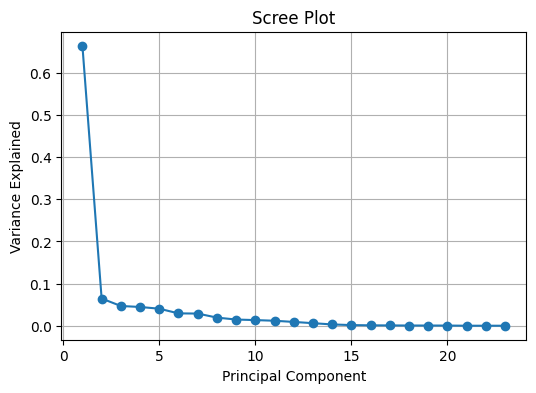

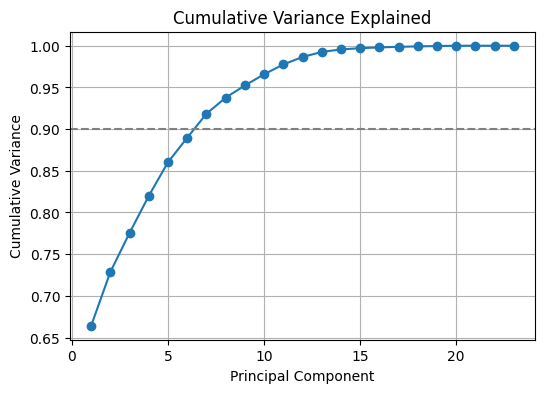


=== PC1 (explained var: 66.41%) ===
TotalRevenue_FY26        0.250
TotalRevenue_FY25        0.248
TotalRevenue_FY24        0.248
TotalRevenue_FY23        0.246
TotalRevenue_FY22        0.244
RevStreamX_FY22          0.239
RevStreamX_FY23          0.237
PotentialRevenue_FY30    0.235
Name: PC1, dtype: float64

=== PC2 (explained var: 6.45%) ===
Revenue_CAGR                 0.614
PI_acct                      0.500
MarketShare_FY30_Category    0.245
Revenue_potential            0.222
MarketShare_FY30_Geo         0.196
PotentialRevenue_FY30        0.174
ProdCatB_Revenue_FY26        0.038
ProdCatC_Revenue_FY26        0.021
Name: PC2, dtype: float64

=== PC3 (explained var: 4.68%) ===
Geo_TAM_FY30                 0.832
MarketShare_FY30_Category    0.169
Revenue_potential            0.054
Revenue_CAGR                 0.050
PotentialRevenue_FY30        0.044
ProdCatD_Revenue_FY26        0.023
ProdCatE_Revenue_FY26        0.022
TotalRevenue_FY26            0.010
Name: PC3, dtype: float64

=== 

In [18]:
#### **1.2 Run Baseline PCA for Dimensionality Reduction**

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- 1) Prepare numeric features ---
exclude_cols = {
    'ID','Geo_Entity','Area_National','Area_Admin','Area_Urban',
    'Commercial_Category','Commercial_Stream','Commercial_Specialty',
    'MarketDomain','MarketTier_FY26','MarketTier_FY25',
    'MarketTier_FY24','MarketTier_FY23','MarketTier_FY22'
}
num_cols = [
    c for c in ContosoRevData.columns
    if c not in exclude_cols
    and pd.api.types.is_numeric_dtype(ContosoRevData[c])
    and ContosoRevData[c].notna().sum() > 0
    and ContosoRevData[c].nunique(dropna=True) > 1
]

# --- 2) Impute & standardize ---
X = ContosoRevData[num_cols].fillna(ContosoRevData[num_cols].mean(numeric_only=True))
scaler = StandardScaler()
X_z = scaler.fit_transform(X)

# --- 3) Fit PCA and select k components (~90% variance) ---
pca = PCA(random_state=0)
X_pca_full = pca.fit_transform(X_z)

explained = pca.explained_variance_ratio_
cumvar = np.cumsum(explained)
k = int(np.searchsorted(cumvar, 0.90) + 1)

print(f"PCA components kept: {k}  (Cumulative variance = {cumvar[k-1]:.3f})")

# --- 4) Refit PCA with k components ---
pca_k = PCA(n_components=k, random_state=0)
X_pca = pca_k.fit_transform(X_z)

# Attach PCs to dataset (shared across all models)
pc_cols = [f"PC{i}" for i in range(1, k+1)]
df_pca = ContosoRevData.copy()
df_pca[pc_cols] = X_pca

print(f"Created PC columns: {', '.join(pc_cols)}")

# --- 5) Scree & cumulative variance plots ---
plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.title("Scree Plot"); plt.xlabel("Principal Component"); plt.ylabel("Variance Explained")
plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(range(1, len(cumvar)+1), cumvar, marker='o')
plt.axhline(0.90, ls='--', color='gray')
plt.title("Cumulative Variance Explained"); plt.xlabel("Principal Component"); plt.ylabel("Cumulative Variance")
plt.grid(True); plt.show()

# --- 6) Loading matrix (for interpretation) ---
loadings = pd.DataFrame(
    pca_k.components_.T,
    index=num_cols,
    columns=pc_cols
)
expl_var = dict(zip(pc_cols, explained[:k]))

def summarize_pc(pc_name, top=8):
    """Print top contributing features for each principal component."""
    w = loadings[pc_name].sort_values()
    pos = w.tail(top)
    print(f"\n=== {pc_name} (explained var: {expl_var[pc_name]:.2%}) ===")
    print(pos.sort_values(ascending=False).round(3))

# Summarize first 7 PCs (used for all models)
for pc in pc_cols[:7]:
    summarize_pc(pc, top=8)


##### **About Baseline PCA Setup**

To ensure consistency across all segmentation models, we perform a single PCA on the unified feature space.  
This step standardizes numeric variables, imputes missing values, and extracts principal components that capture ~90% of total variance.  
All models (Ward, K-Means, Ward2, etc.) will use **the same PCA-transformed dataset (`df_pca`)** to ensure results are coherent and directly comparable.

----


## **2. Segmentation Modeling**

#### 2.0 Ward Model Setup & Helpers

In [19]:
## safe disregard warnings
import warnings
warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    module="sklearn.utils.extmath"
)

In [20]:
def map_clusters_to_tiers(
    df: pd.DataFrame,
    cluster_col: str,
    pi_col: str,
    rev_col: str,
    policy: TierPolicy
) -> dict:
    """
    Returns a dict {cluster_id: 'Tier A'/'Tier B'/...} based on the policy’s ranking.
    """
    # 1) Score clusters by the policy
    scores = policy.rank_key(df, cluster_col, pi_col, rev_col)  # index: cluster_id
    scores = scores.dropna()

    # 2) Order cluster ids by ascending score (lower is better)
    ordered_cluster_ids = list(scores.sort_values(ascending=False).index)

    # 3) Make labels A..N with same length K
    k = len(ordered_cluster_ids)
    labels = policy.make_labels(k)

    # 4) Build mapping {cluster_id -> tier_label}
    mapping = {cid: labels[i] for i, cid in enumerate(ordered_cluster_ids)}
    return mapping


In [21]:
from sklearn.cluster import AgglomerativeClustering
import pandas as pd

def run_ward_with_policy(
    df_pca: pd.DataFrame,
    policy,
    policy_name: str = "Policy",
    k: int = 4,
    n_pcs: int = 7,
    pi_col: str = "PI_acct",
    rev_col: str = "TotalRevenue_FY26",
    sfi_mode: str = "top_L_tiers",
    sfi_param: int = 2,
):
    """
    Generic helper for Model A:
      - Fit Ward with K clusters on first n_pcs PCs
      - Map clusters -> tiers using the given `policy` via `map_clusters_to_tiers`
      - Compute Silhouette
      - Compute KPIs
      - Return (kpis, df_labeled)

    Assumes:
      - `map_clusters_to_tiers` ordering must be fixed to（ascending=False）
      - `policy` is a tierPolicy object like tier_policy / tier_policy2 we previously defined
      - `policy_name` is just a string description of that tier policy used
    """

    # 1) Build Ward input matrix
    pc_cols = [c for c in df_pca.columns if c.startswith("PC")][:n_pcs]
    Xm = df_pca[pc_cols].to_numpy()

    # 2) Ward clustering
    lab = AgglomerativeClustering(n_clusters=k, linkage="ward").fit_predict(Xm)

    # 3) Working df
    tmp = df_pca.copy()
    tmp["cluster"] = lab

    # 4) Cluster -> Tier via *your* map_clusters_to_tiers (ascending=False)
    cmap = map_clusters_to_tiers(
        tmp,
        cluster_col="cluster",
        pi_col=pi_col,
        rev_col=rev_col,
        policy=policy
    )
    tmp["TierCol"] = tmp["cluster"].map(cmap)

    # 5) Silhouette（用同样的 PC 空间）
    sil = compute_silhouette_ward(
        tmp,        # 已经有 "TierCol"
        df_pca,
        tier_col="TierCol",
        n_pcs=n_pcs
    )

    # 6) KPIs
    kpis = compute_kpis(
        tmp,
        tier_col="TierCol",
        pi_col=pi_col,
        rev_col=rev_col,
        sfi_mode=sfi_mode,
        sfi_param=sfi_param,
        sil_value=sil
    )

    # meta info
    kpis["Policy"] = policy_name
    kpis["K"] = k
    kpis["Strategic_Tiers"] = kpis.get("Strategic_Tiers", ["Tier A", "Tier B"])

    return kpis, tmp


In [22]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def compute_silhouette_ward(df_labeled, df_pca, tier_col="TierCol", n_pcs=7):
    """
    Drop-in silhouette for Ward-like models.
    - df_labeled: DataFrame containing a categorical cluster/tier column.
    - df_pca:     PCA feature DataFrame (rows aligned by index to df_labeled).
    - tier_col:   column name in df_labeled with cluster/tier labels.
    - n_pcs:      number of PCs to use (default 7).
    Returns float in [-1, 1] or np.nan if not computable.
    """
    try:
        # 1) Align rows (keeps your existing call sites unchanged)
        idx = df_labeled.index.intersection(df_pca.index)
        if len(idx) == 0 or tier_col not in df_labeled.columns:
            return np.nan

        # 2) Take first n PCs (columns starting with "PC")
        pc_cols = [c for c in df_pca.columns if str(c).startswith("PC")][:int(n_pcs)]
        if len(pc_cols) == 0:
            return np.nan

        X = df_pca.loc[idx, pc_cols].to_numpy(dtype=float)
        y = df_labeled.loc[idx, tier_col]

        # 3) Factorize labels (Ward/KMeans-style)
        labels, _ = pd.factorize(y, sort=True)

        # Guard: need ≥ 2 clusters and each cluster size ≥ 2
        if np.unique(labels).size < 2:
            return np.nan
        vc = pd.Series(labels).value_counts()
        if (vc < 2).any():
            return np.nan

        # 4) Sanitize + standardize to stabilize distances
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
        X = np.clip(X, -1e3, 1e3)  # tame extreme values
        X = StandardScaler().fit_transform(X)

        # 5) Silhouette (euclidean)
        sil = silhouette_score(X, labels, metric="euclidean")
        return float(sil)

    except Exception:
        return np.nan
    
def compute_tier_summary(df, tier_col, tier_order):
    out = (
        df.groupby(tier_col)
          .agg(
              accounts=("ID", "count"),
              rev_sum=("TotalRevenue_FY26", "sum"),
              pi_mean=("PI_acct", "mean"),
          )
          .assign(
              rev_share=lambda d: d["rev_sum"] / (d["rev_sum"].sum() + 1e-12)
          )
    )
    return out.reindex(tier_order)


In [23]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd

def plot_pi_by_tier_models(
    df_base,
    df_policy_v1,
    df_policy_v2,
    tier_col_base="TierFY26",
    tier_col_policy="TierCol",
    title_suffix=" (K=4 Ward)",
    tier_order=["Tier A", "Tier B", "Tier C", "Tier D"],
):
    """
    Plot Mean PI by tier for:
      - Baseline FY26
      - Policy v1
      - Policy v2
    Each model gets its own subplot.
    """
    sum_base = compute_tier_summary(df_base,      tier_col_base, tier_order)
    sum_v1   = compute_tier_summary(df_policy_v1, tier_col_policy, tier_order)
    sum_v2   = compute_tier_summary(df_policy_v2, tier_col_policy, tier_order)

    series = [
        ("Baseline FY26",       sum_base["pi_mean"]),
        ("Policy v1 (PI-only)", sum_v1["pi_mean"]),
        ("Policy v2 (PI+Rev)",  sum_v2["pi_mean"]),
    ]

    pi_ymax = 1.1 * max(s.max() for _, s in series)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

    for ax, (label, s) in zip(axes, series):
        s.reindex(tier_order).plot(kind="bar", ax=ax)
        ax.set_title(f"{label}{title_suffix}")
        ax.set_xlabel("Tier")
        ax.set_ylabel("Mean PI (normalized)")
        ax.set_ylim(0, pi_ymax)
        ax.grid(True, axis="y")

    plt.show()
    return fig, axes

def plot_rev_share_by_tier_models(
    df_base,
    df_policy_v1,
    df_policy_v2,
    tier_col_base="TierFY26",
    tier_col_policy="TierCol",
    title_suffix=" (K=4 Ward)",
    tier_order=["Tier A", "Tier B", "Tier C", "Tier D"],
):
    """
    Plot Revenue share by tier for:
      - Baseline FY26
      - Policy v1
      - Policy v2
    Each model gets its own subplot.
    """
    sum_base = compute_tier_summary(df_base,      tier_col_base, tier_order)
    sum_v1   = compute_tier_summary(df_policy_v1, tier_col_policy, tier_order)
    sum_v2   = compute_tier_summary(df_policy_v2, tier_col_policy, tier_order)

    series = [
        ("Baseline FY26",       sum_base["rev_share"]),
        ("Policy v1 (PI-only)", sum_v1["rev_share"]),
        ("Policy v2 (PI+Rev)",  sum_v2["rev_share"]),
    ]

    rev_ymax = 1.1 * max(s.max() for _, s in series)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

    for ax, (label, s) in zip(axes, series):
        s.reindex(tier_order).plot(kind="bar", ax=ax)
        ax.set_title(f"{label}{title_suffix}")
        ax.set_xlabel("Tier")
        ax.set_ylabel("Revenue share")
        ax.set_ylim(0, rev_ymax)
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
        ax.grid(True, axis="y")

    plt.show()
    return fig, axes


---- 

### **2.1 Model A: Ward Hierarchical Clustering**
- Ward’s linkage: minimizes the total sum of squared differences (SSD) within all clusters (aka “inertia”).
- Unlike KMeans, which assigns clusters based on centroids directly, Ward clustering builds a dendrogram (tree of merges) and cuts it at a desired number of clusters.

Ward minimizes within-cluster variance. We run it on the shared PCA features to keep inputs identical across models. We’ll first reproduce the **legacy SFI (label-based “A+B”)** vs. **the corrected Tier Policy**, then **tune K**.

#### **2.1.1 Model A: Base Model (K = 4)**

##### a) Base model code

In [24]:
# --- Run Ward + Policy v1 ---
k_policy_v1, df_policy_v1 = run_ward_with_policy(
    df_pca,
    policy=tier_policy,
    policy_name="Policy v1 (PI-only)",
    k=4,
    n_pcs=7
)


##### b) KPIs (legacy vs. policy)

In [25]:
# Compare 
render_kpis_compare(
    [
        ("FY26 Baseline (Given, Legacy Model)", kpis_FY26),
        ("Ward K=4 (Tier Policy v1)", k_policy_v1),
    ],
    title="KPI Comparison — FY26 Baseline vs Ward Policy"
)

,"FY26 Baseline (Given, Legacy Model)",Ward K=4 (Tier Policy v1)
TPA,0.260,0.310
TCI_PI,0.222,0.461
TCI_REV,0.469,0.801
SFI,0.807,0.132
Silhouette,nan,0.560


**Observations**：
- suspecting negative correlation between `SFI` and `Sil`;
- `SFI` never exceeds 0.5 in current model setup
- `Sil` is way too low for a distinctive clustering

- Thoughts: SFI drop from 0.868 → 0.132 was too extreme to be a realistic “policy refinement effect”; it points to a modeling setup or metric interpretation issue rather than a genuine business tradeoff.
- The extreme SFI drop is not a modeling failure per se but a mismatch between statistical structure and business tiering definition.

- Next steps: sanity check on SFI. Right now our $SFI = revenue(top-L tiers) / total\_revenue$, with
$L = 2$ and $tier_col = TierCol$ (mapped via policy).

So if our tier mapping (`map_clusters_to_tiers`) ranks clusters by PI mean, but our cluster composition is highly uneven, we might end up with:
- top-2 tiers containing very few high-PI accounts, but the majority of total revenue sitting in lower tiers (C/D).
- That would yield exactly what we’re seeing — strong structure (Sil=0.56) but tiny SFI.

#### 2.1.x.1 Re-evaluate and Update Tier Policy (legacy vs. policy1 vs. policy1)

The current tier policy actually favors average potential (good for compact PI tiers but penalizes volume-heavy clusters).

From below, we see tier A&B only accounts for 11% of total revenue, which was the opposite of what we want.

In [26]:
df_policy_v1.groupby("TierCol")["TotalRevenue_FY26"].sum() / df_policy_v1["TotalRevenue_FY26"].sum()


TierCol
Tier A    0.040128
Tier B    0.091739
Tier C    0.342415
Tier D    0.525718
Name: TotalRevenue_FY26, dtype: float64

In [27]:
# --- Run Ward + Policy v2 ---
k_policy_v2, df_policy_v2 = run_ward_with_policy(
    df_pca,
    policy=tier_policy2,
    policy_name="Policy v2 (PI+Rev weighted)",
    k=4,
    n_pcs=7
)

In [28]:
# --- Compare KPIs (unchanged output) ---
render_kpis_compare(
    [
        ("FY26 Baseline (Legacy)",             kpis_FY26),
        ("Ward K=4 (Policy v1: mean PI)",      k_policy_v1),
        ("Ward K=4 (Policy v2: PI+Rev weighted)", k_policy_v2),
    ],
    title="Ward K=4 — KPI Comparison (Baseline vs Policy v1 vs Policy v2, SFI = A+B labels)"
)


# --- Compare cluster → tier mappings ---
mapping_view = render_cluster_mapping(df_policy_v1, df_policy_v2)


# --- Compare revenue shares ---
rev_share_table = render_rev_share_with_baseline(
    df_base,
    tier_col_base="TierFY26",
    df_policy_v1=df_policy_v1,
    df_policy_v2=df_policy_v2,
)


,FY26 Baseline (Legacy),Ward K=4 (Policy v1: mean PI),Ward K=4 (Policy v2: PI+Rev weighted)
TPA,0.260,0.310,0.260
TCI_PI,0.222,0.461,0.461
TCI_REV,0.469,0.801,0.801
SFI,0.807,0.132,0.868
Silhouette,nan,0.560,0.560



=== Cluster → Tier Mapping ===


,cluster,Policy_v1,Policy_v2
0,0,Tier C,Tier A
1,1,Tier D,Tier B
2,2,Tier A,Tier C
3,3,Tier B,Tier D



=== Revenue Share by Tier (Baseline vs Policies) ===


,rev_share_baseline,rev_share_v1,rev_share_v2
Tier A,0.333359,0.040128,0.342415
Tier B,0.473411,0.091739,0.525718
Tier C,0.051939,0.342415,0.040128
Tier D,0.141292,0.525718,0.091739


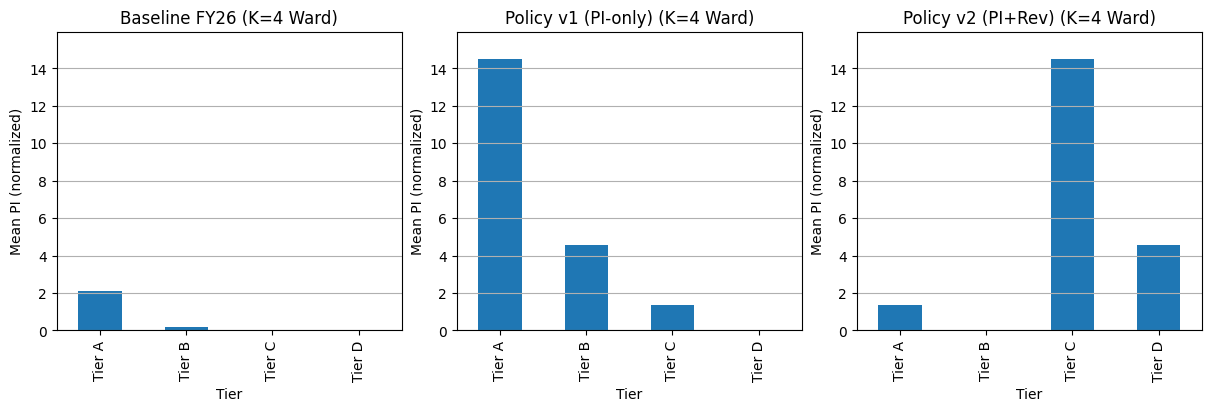

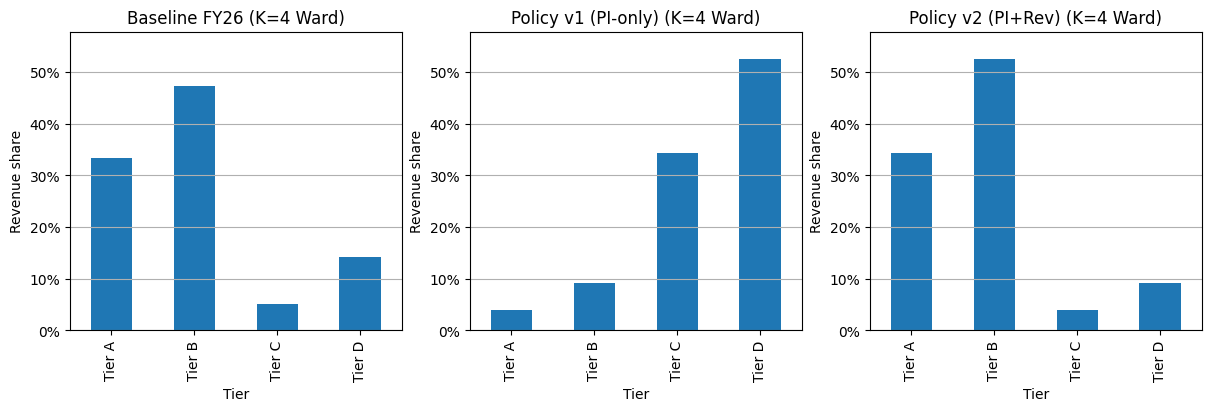

In [29]:
#### render bar chart
fig_pi, axes_pi = plot_pi_by_tier_models(df_base, df_policy_v1, df_policy_v2)
fig_rev, axes_rev = plot_rev_share_by_tier_models(df_base, df_policy_v1, df_policy_v2)


##### **Summary — Baseline vs Policy v1 vs Policy v2**

- **Baseline (FY26):**  
  - Revenue concentrated in **Tier A+B (~80%) → SFI ≈ 0.81**.  
  - **Weak PI separation**, as shown by tiers sitting close together in the PI chart.

- **Policy v1 (PI-only):**  
  - **Strongest PI separation** (tiers spread widely in the PI chart).  
  - But revenue shifts heavily into **Tier C+D**, causing **SFI to fall to ~0.13**.

- **Policy v2 (PI+Rev):**  
  - Retains **the same separation structure** as v1 (similar PI pattern).  
  - Reassigns high-revenue clusters into **Tier A+B**, lifting **SFI to ~0.87** — exceeding the FY26 baseline.  
  - Visuals show: PI ≈ v1, revenue distribution ≈ baseline.

**Bottom line:**  
**v1 = best separation but loses revenue focus.  
v2 = preserves Ward separation while restoring strong A+B revenue concentration.**


#### 2.1.x.2 Tune Tier Policy by Grid Search

In [30]:
def grid_search_tier_policy_weights(
    df_pca,
    k=4,
    n_pcs=7,
    w_pi_grid=None,
    base_label="Linear PI/Rev policy"
):
    """
    Run Ward + TierPolicy for a grid of PI weights.
    Returns:
      - df_grid: table of KPIs per w_pi
      - kpi_dict: {w_pi: kpi_dict}
    """
    if w_pi_grid is None:
        # 你可以自己改，这里在 0.5–0.7 之间扫几档
        w_pi_grid = np.linspace(0.5, 0.7, 5)   # 0.50, 0.55, 0.60, 0.65, 0.70

    rows = []
    kpi_dict = {}

    for w_pi in w_pi_grid:
        policy = make_tier_policy_linear(w_pi)
        policy_name = f"{base_label} (w_pi={w_pi:.2f}, w_rev={1-w_pi:.2f})"

        kpis, df_pol = run_ward_with_policy(
            df_pca,
            policy=policy,
            policy_name=policy_name,
            k=k,
            n_pcs=n_pcs,
        )

        kpi_dict[w_pi] = (kpis, df_pol)

        row = {
            "w_pi":  w_pi,
            "w_rev": 1.0 - w_pi,
            "TPA":  kpis["TPA"],
            "TCI_PI": kpis["TCI_PI"],
            "TCI_REV": kpis["TCI_REV"],
            "SFI":  kpis["SFI"],
            "Silhouette": kpis["Silhouette"],
        }
        rows.append(row)

    df_grid = pd.DataFrame(rows).sort_values("w_pi")
    return df_grid, kpi_dict


In [31]:
# w_pi from 0.00 → 0.50
w_pi_grid = np.linspace(0.5, 0.7, 9)  # 0.50, 0.525, ..., 0.70
df_grid, kpi_dict = grid_search_tier_policy_weights(
    df_pca,
    k=4,
    n_pcs=7,
    w_pi_grid=w_pi_grid,
    base_label="Policy (linear PI/Rev)",
)

display(df_grid.style.format({"SFI": "{:.3f}", "TPA": "{:.3f}", "Silhouette": "{:.3f}"}))


,w_pi,w_rev,TPA,TCI_PI,TCI_REV,SFI,Silhouette
0,0.500000,0.500000,0.256,0.461000,0.801000,0.868,0.560
1,0.525000,0.475000,-0.310,0.461000,0.801000,0.868,0.560
2,0.550000,0.450000,-0.310,0.461000,0.801000,0.868,0.560
3,0.575000,0.425000,-0.310,0.461000,0.801000,0.868,0.560
4,0.600000,0.400000,-0.310,0.461000,0.801000,0.868,0.560
5,0.625000,0.375000,-0.310,0.461000,0.801000,0.868,0.560
6,0.650000,0.350000,-0.310,0.461000,0.801000,0.868,0.560
7,0.675000,0.325000,-0.310,0.461000,0.801000,0.868,0.560
8,0.700000,0.300000,-0.310,0.461000,0.801000,0.868,0.560


In [32]:
# w_pi from 0.00 → 0.50
w_pi_grid2 = np.linspace(0.0, 0.5, 11)   # 0.00, 0.05, ..., 0.50

df_grid2, kpi_dict2 = grid_search_tier_policy_weights(
    df_pca,
    k=4,
    n_pcs=7,
    w_pi_grid=w_pi_grid2,
    base_label="Policy (linear PI/Rev)",
)

display(df_grid2.style.format({"SFI":"{:.3f}","TPA":"{:.3f}","Silhouette":"{:.3f}"}))


,w_pi,w_rev,TPA,TCI_PI,TCI_REV,SFI,Silhouette
0,0.000000,1.000000,0.310,0.461000,0.801000,0.132,0.560
1,0.050000,0.950000,0.310,0.461000,0.801000,0.132,0.560
2,0.100000,0.900000,0.310,0.461000,0.801000,0.132,0.560
3,0.150000,0.850000,0.310,0.461000,0.801000,0.132,0.560
4,0.200000,0.800000,0.310,0.461000,0.801000,0.132,0.560
5,0.250000,0.750000,0.310,0.461000,0.801000,0.132,0.560
6,0.300000,0.700000,0.310,0.461000,0.801000,0.132,0.560
7,0.350000,0.650000,0.310,0.461000,0.801000,0.132,0.560
8,0.400000,0.600000,0.310,0.461000,0.801000,0.132,0.560
9,0.450000,0.550000,0.310,0.461000,0.801000,0.132,0.560


In [33]:
# Combine 
df_grid_all = pd.concat([df_grid, df_grid2], ignore_index=True)

# optional: drop duplicates if w_pi=0.5 appears twice
df_grid_all = df_grid_all.drop_duplicates(subset=["w_pi"]).sort_values("w_pi").reset_index(drop=True)

df_grid_all = (
    df_grid_all
    .drop_duplicates(subset=["w_pi"])
    .sort_values("w_pi")
    .reset_index(drop=True)
)

display(df_grid_all)


,w_pi,w_rev,TPA,TCI_PI,TCI_REV,SFI,Silhouette
0,0.000,1.000,0.310,0.461,0.801,0.132,0.560188
1,0.050,0.950,0.310,0.461,0.801,0.132,0.560188
2,0.100,0.900,0.310,0.461,0.801,0.132,0.560188
3,0.150,0.850,0.310,0.461,0.801,0.132,0.560188
4,0.200,0.800,0.310,0.461,0.801,0.132,0.560188
5,0.250,0.750,0.310,0.461,0.801,0.132,0.560188
6,0.300,0.700,0.310,0.461,0.801,0.132,0.560188
7,0.350,0.650,0.310,0.461,0.801,0.132,0.560188
8,0.400,0.600,0.310,0.461,0.801,0.132,0.560188
9,0.450,0.550,0.310,0.461,0.801,0.132,0.560188


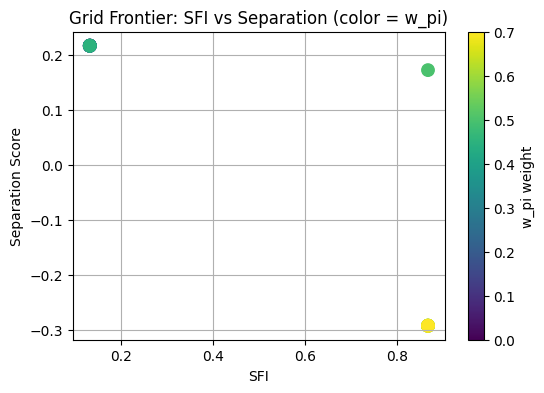

In [34]:
# SFI vs Separation scatter

sep_cols = ["TPA", "TCI_PI", "TCI_REV", "Silhouette"]

def add_separation_score(df_grid):
    df = df_grid.copy()
    # z-score each separation KPI across the grid
    for c in sep_cols:
        mu = df[c].mean()
        sd = df[c].std(ddof=0) + 1e-12
        df[c + "_z"] = (df[c] - mu) / sd

    # separation_score = average of the 4 z-scores
    df["separation_score"] = df[[c + "_z" for c in sep_cols]].mean(axis=1)
    return df


df_all = add_separation_score(df_grid_all)

plt.figure(figsize=(6,4))
plt.scatter(df_all["SFI"], df_all["separation_score"], c=df_all["w_pi"], cmap="viridis", s=80)
plt.colorbar(label="w_pi weight")
plt.xlabel("SFI")
plt.ylabel("Separation Score")
plt.title("Grid Frontier: SFI vs Separation (color = w_pi)")
plt.grid(True)
plt.show()


In [35]:
# Pareto frontier extraction
df_all["w_pi"] = pd.to_numeric(df_all["w_pi"], errors="coerce")
df_sorted = df_all.sort_values("w_pi")
frontier = df_sorted[df_sorted["separation_score"] == df_sorted.groupby("SFI")["separation_score"].transform("max")]


In [36]:
render_grid_table(df_sorted, title="Ward K=4 — Tier Policy Weight Grid Search KPIs")

,w_pi,w_rev,TPA,TCI_PI,TCI_REV,SFI,Silhouette,TPA_z,TCI_PI_z,TCI_REV_z,Silhouette_z,separation_score
0,0.000,1.000,0.310,0.461,0.801,0.132,0.560,0.868311,0.000000,0.000000,0.000111,0.217106
1,0.050,0.950,0.310,0.461,0.801,0.132,0.560,0.868311,0.000000,0.000000,0.000111,0.217106
2,0.100,0.900,0.310,0.461,0.801,0.132,0.560,0.868311,0.000000,0.000000,0.000111,0.217106
3,0.150,0.850,0.310,0.461,0.801,0.132,0.560,0.868311,0.000000,0.000000,0.000111,0.217106
4,0.200,0.800,0.310,0.461,0.801,0.132,0.560,0.868311,0.000000,0.000000,0.000111,0.217106
5,0.250,0.750,0.310,0.461,0.801,0.132,0.560,0.868311,0.000000,0.000000,0.000111,0.217106
6,0.300,0.700,0.310,0.461,0.801,0.132,0.560,0.868311,0.000000,0.000000,0.000111,0.217106
7,0.350,0.650,0.310,0.461,0.801,0.132,0.560,0.868311,0.000000,0.000000,0.000111,0.217106
8,0.400,0.600,0.310,0.461,0.801,0.132,0.560,0.868311,0.000000,0.000000,0.000111,0.217106
9,0.450,0.550,0.310,0.461,0.801,0.132,0.560,0.868311,0.000000,0.000000,0.000111,0.217106


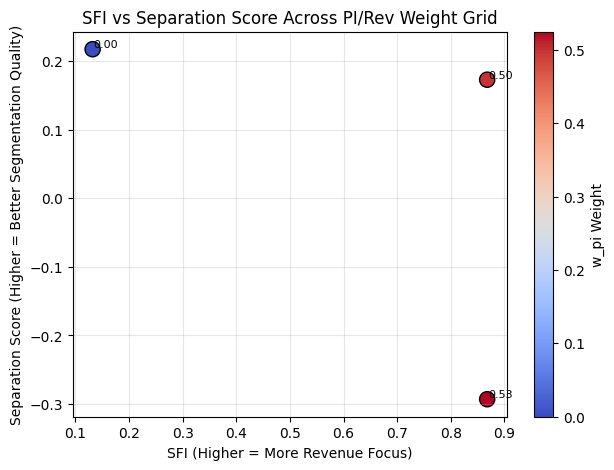

In [37]:
import matplotlib.pyplot as plt

df_unique = df_sorted.copy()

df_unique = df_all.drop_duplicates(
    subset=["SFI", "separation_score"]
).sort_values("w_pi")


plt.figure(figsize=(7,5))

plt.scatter(
    df_unique["SFI"],
    df_unique["separation_score"],
    c=df_unique["w_pi"],
    cmap="coolwarm",
    s=120,
    edgecolors="black"
)

for _, row in df_unique.iterrows():
    plt.text(row["SFI"]+0.002, row["separation_score"]+0.002, 
             f"{row['w_pi']:.2f}", fontsize=8)

plt.xlabel("SFI (Higher = More Revenue Focus)")
plt.ylabel("Separation Score (Higher = Better Segmentation Quality)")
plt.title("SFI vs Separation Score Across PI/Rev Weight Grid")

cbar = plt.colorbar()
cbar.set_label("w_pi Weight")

plt.grid(True, alpha=0.3)
plt.show()


##### **Summary: Final Grid-Search Conclusion**

Our PI/Revenue weight sweep shows that Ward segmentation is highly stable and produces **only three distinct outcomes**:

1. **w_pi < 0.50 — PI-dominant**  
   - Best separation, but **SFI collapses (~0.13)** → not business-viable.

2. **w_pi = 0.50 — Transition point**  
   - **SFI jumps to ~0.87** (same as baseline A+B focus)  
   - Separation remains acceptable.

3. **w_pi > 0.50 — Revenue-dominant**  
   - Same SFI (~0.87) but **weaker separation** than w_pi=0.50.

### ⭐ **Recommended Weight: w_pi = 0.50 (PI:Rev = 50:50)**  
- The **only** setting that balances strong revenue focus with solid separation.  
- Lower weights lose business alignment; higher weights bring no SFI gain and reduce model quality.

**→ w_pi = 0.50 is the unique sweet spot.**


----


#### **2.1.2 Under Mean PI Policy (How to Fix Low SFI)**

**If SFI is low → Try model-side fixes (2.1.2):**  
 1️⃣ **Ward2-A (Post-model Reallocation)**  
  - Promote borderline high-PI accounts into Tier B  
  - Cap total revenue moved ≤10%  
  - Transparent but limited lift  

 2️⃣ **Ward2-B/B+ (Weighted Features)**  
  - Inject PI/revenue signals before clustering  
  - Tune α, β, pc_scale  
  - Slight SFI gain but still constrained by Policy v1 labels  


 👉 *Outcome:* Both methods improved SFI marginally but couldn’t fix structural imbalance.

##### **2.1.2.A Ward2-A: Post-model Re-allocation (rule-based)**
Small promotions of borderline high-PI accounts from non-strategic tiers into the lowest strategic tier until SFI hits a target (with safeguards).

In [46]:
def run_ward2A_reallocation(
    df_ward_labeled: pd.DataFrame,
    df_pca: pd.DataFrame,
    *,
    tier_col: str = "TierCol",
    pi_col: str = "PI_acct",
    rev_col: str = "TotalRevenue_FY26",
    strategic_tiers,
    target_sfi: float = 0.60,
    max_rev_pct: float = 0.10,
    batch: int = 200,
    n_pcs: int = 7,
    sfi_mode: str = "top_L_tiers",
    sfi_param: int = 2,
    policy_name: str = "Ward2-A (Re-allocation)",
):
    """
    Inputs:
      - df_ward_labeled: dataframe already containing tier_col from Ward + Policy
      - df_pca: PCA matrix used only for silhouette
      - strategic_tiers: ['Tier A','Tier B']
      - tier_col: name of tier column in df_ward_labeled
    """
    # --- 1) Start from labeled df (not df_pca)
    d = df_ward_labeled.copy()

    total_rev = d[rev_col].sum() + 1e-12
    moved_rev = 0.0
    dest = sorted(strategic_tiers)[-1]  # lowest strategic tier

    def cur_sfi():
        return d.loc[d[tier_col].isin(strategic_tiers), rev_col].sum() / total_rev

    pool = d.loc[~d[tier_col].isin(strategic_tiers)].sort_values(pi_col, ascending=False)

    i = 0
    while (
        cur_sfi() < target_sfi
        and moved_rev / total_rev < max_rev_pct
        and i < len(pool)
    ):
        idx = pool.index[i:i+batch]
        moved_rev += pool.loc[idx, rev_col].sum()
        d.loc[idx, tier_col] = dest
        i += batch

    # --- 2) Silhouette using PCA space
    sil = compute_silhouette_ward(
        d,
        df_pca,
        tier_col=tier_col,
        n_pcs=n_pcs
    )

    # --- 3) KPIs
    kpis = compute_kpis(
        d,
        tier_col=tier_col,
        pi_col=pi_col,
        rev_col=rev_col,
        sfi_mode=sfi_mode,
        sfi_param=sfi_param,
        sil_value=sil
    )

    kpis["Policy"] = policy_name
    kpis["Strategic_Tiers"] = strategic_tiers

    return kpis, d


In [47]:
# Step 2: Ward2-A
k_ward2A, df_ward2A = run_ward2A_reallocation(
    df_ward_labeled=df_policy_v1,          # ✔ has TierCol
    df_pca=df_pca,                         # ✔ used for silhouette
    strategic_tiers=k_policy_v1["Strategic_Tiers"],
)

# Step 3: Compare
render_kpis_compare(
    [
        ("Ward K=4 (Policy v1)", k_policy_v1),
        ("Ward2-A (Re-allocation)", k_ward2A),
    ]
)



,Ward K=4 (Policy v1),Ward2-A (Re-allocation)
TPA,0.310,0.310
TCI_PI,0.461,0.516
TCI_REV,0.801,0.743
SFI,0.132,0.241
Silhouette,0.560,0.470


**Summary — Ward2-A**

- **SFI:** ↑ 0.132 → 0.241  
- **TCI_PI:** ↑ 0.461 → 0.516  
- **TCI_REV:** slight ↓ (expected)  
- **Silhouette:** ↓ (tier reshuffling)

**Takeaway:**  
Minor upward moves of high-PI accounts lift business KPIs with modest loss in separation.


##### **2.1.2.B Ward2-B: Weighted Clustering Objective (feature weighting)**
Agglomerative Ward can’t take sample weights directly, so we inject a strategic signal by scaling features fed to clustering. We append a standardized `PI_acct` and (optionally) FY26 revenue to the model matrix with larger weights.

In [53]:
# ============================================================
# Ward2-B: Weighted features (PI + Rev) + optional PC scaling
# ============================================================
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import pandas as pd

def run_ward_weighted(
    df_pca: pd.DataFrame,
    *,
    policy,
    policy_name: str = "Ward2-B (Weighted PI + Rev)",
    k: int = 4,
    n_pcs: int = 7,
    alpha: float = 2.0,          # PI weight
    beta: float = 0.5,           # Rev weight (0 = disable)
    pc_scale: float = 1.0,       # scale factor applied to PCs
    pi_col: str = "PI_acct",
    rev_col: str = "TotalRevenue_FY26",
    sfi_mode: str = "top_L_tiers",
    sfi_param: int = 2,
):
    """
    Weighted Ward:
      - PCs scaled by pc_scale
      - alpha * z-scored PI
      - beta  * z-scored revenue
    Then:
      - Ward clustering
      - Cluster → Tier via policy
      - Silhouette (on PCA space)
      - KPIs assembly
    """

    # 1) First n PCs with scaling
    pc_cols = [c for c in df_pca.columns if c.startswith("PC")][:n_pcs]
    pcs = df_pca[pc_cols].to_numpy(dtype=float) * float(pc_scale)

    # 2) Weighted signals (z-scored)
    pi = df_pca[pi_col].to_numpy(float)
    rv = df_pca[rev_col].to_numpy(float)

    pi_z = (pi - pi.mean()) / (pi.std(ddof=0) + 1e-12)
    rv_z = (rv - rv.mean()) / (rv.std(ddof=0) + 1e-12)

    Xm = np.column_stack([pcs, alpha * pi_z, beta * rv_z])
    Xm = np.nan_to_num(Xm, nan=0.0, posinf=0.0, neginf=0.0)

    # 3) Ward clustering
    labels = AgglomerativeClustering(n_clusters=k, linkage="ward").fit_predict(Xm)

    tmp = df_pca.copy()
    tmp["cluster"] = labels

    # 4) Cluster → Tier
    cmap = map_clusters_to_tiers(
        tmp,
        cluster_col="cluster",
        pi_col=pi_col,
        rev_col=rev_col,
        policy=policy,
    )
    tmp["TierCol"] = tmp["cluster"].map(cmap)

    # 5) Silhouette
    sil = compute_silhouette_ward(tmp, df_pca, tier_col="TierCol", n_pcs=n_pcs)

    # 6) KPIs
    kpis = compute_kpis(
        tmp,
        tier_col="TierCol",
        pi_col=pi_col,
        rev_col=rev_col,
        sfi_mode=sfi_mode,
        sfi_param=sfi_param,
        sil_value=sil,
    )

    # Metadata (保持你的原风格)
    kpis["Policy"] = policy_name
    kpis["K"] = k
    kpis["Alpha"] = alpha
    kpis["Beta"] = beta
    kpis["PC_Scale"] = pc_scale
    kpis["Strategic_Tiers"] = kpis.get("Strategic_Tiers", ["Tier A", "Tier B"])

    return kpis, tmp


In [54]:
# --- Run Ward2-B on top of PCA with Policy v1 ---
alpha = 2.0
beta = 0.5

k_weighted, df_weighted = run_ward_weighted(
    df_pca,
    policy=tier_policy,                     # or tier_policy_v1, depending on naming
    policy_name="Ward2-B (Weighted PI + Rev)",
    k=4,
    n_pcs=7,
    alpha=alpha,
    beta=beta,
)



In [55]:

# --- KPI comparison vs Ward K=4 under Policy v1 ---
render_kpis_compare(
    [
        ("Ward K=4 (Policy v1)", k_policy_v1),
        ("Ward2-B (Weighted features)", k_weighted),
    ],
    title="Ward → Ward2-B (Weighted PI/Rev signals)",
)

tier_order = k_policy_v1.get(
    "Tier_Order",
    sorted(df_weighted["TierCol"].unique()),
)

summary_weighted = compute_tier_summary(
    df_weighted,
    tier_col="TierCol",
    tier_order=tier_order,
)

display(
    summary_weighted.style
        .format({"rev_sum": "{:,.0f}", "rev_share": "{:.1%}", "pi_mean": "{:.3f}"})
        .set_caption("Ward2-B Tier Summary"),
)


,Ward K=4 (Policy v1),Ward2-B (Weighted features)
TPA,0.310,0.330
TCI_PI,0.461,0.476
TCI_REV,0.801,0.802
SFI,0.132,0.232
Silhouette,0.560,0.464


,accounts,rev_sum,pi_mean,rev_share
TierCol,,,,
Tier A,20,"19,678,274,815",14.517,4.0%
Tier B,408,"93,885,607,592",3.251,19.1%
Tier C,1801,"130,991,828,104",1.093,26.7%
Tier D,47771,"245,837,497,916",-0.075,50.1%


 **Summary — Ward2-B (Weighted PI/Rev Signals)**

- **SFI:** ↑ 0.132 → 0.232  
- **TCI_PI:** ↑ 0.461 → 0.476  
- **TPA:** ↑ 0.310 → 0.330  
- **Silhouette:** ↓ 0.560 → 0.464（inject weighted signals → weaker compactness）

**Takeaway:**  
Weighted PI/Rev strengthens strategic alignment (SFI + TCI_PI) with a modest separation trade-off.


##### **2.1.2.B+ Ward2-B+ (Heavier potential weighting).**  
We inject business intent *before* clustering by boosting the potential signal (`PI_acct`) and (optionally) FY26 revenue, while slightly down-weighting the original PCs. This makes clusters more “potential-aware,” which lifts SFI without post-hoc relabeling.


**Quick grid search over alpha ∈ {4,5,6} (keep beta/pc_scale fixed)**

Params Explanation:
- `alpha` (PI weight): multiplies the standardized potential score before clustering. Higher = clusters prioritize high-potential accounts → usually ↑TPA, ↑TCI_PI, and ↑SFI (up to a point).

- `beta` (revenue weight): adds stabilized revenue as a clustering signal. Small-to-moderate values help SFI without letting revenue dominate (keep business intent = potential first).

- `pc_scale` (PC attenuation): scales original PCs. Values < 1 reduce their sway so injected business signals can steer the clusters. Too low can overfit to PI/Rev and hurt separation on other axes (watch TCI_REV).

In [59]:
# ------------------------------------------------------------
# Ward2-B Grid Search (with compact progress logs)
# ------------------------------------------------------------
import pandas as pd
import numpy as np

# Parameter space
N_PCS   = 7
K_LIST  = [4]
ALPHAS  = [2, 3, 4, 5, 6]
BETAS   = [0.5, 0.8, 1.0]
PC_SCLS = [0.5, 0.7, 0.9]

records = []

total = len(K_LIST) * len(ALPHAS) * len(BETAS) * len(PC_SCLS)
step = 0

# Grid search
for k in K_LIST:
    for a in ALPHAS:
        for b in BETAS:
            for s in PC_SCLS:
                step += 1

                kpis, _df = run_ward_weighted(
                    df_pca,
                    policy=tier_policy,
                    alpha=a,
                    beta=b,
                    pc_scale=s,
                    n_pcs=N_PCS,
                    k=k,
                )

                # compact progress print
                tpa = kpis.get("TPA", np.nan)
                tci_pi = kpis.get("TCI_PI", np.nan)
                tci_rev = kpis.get("TCI_REV", np.nan)
                sfi = kpis.get("SFI", np.nan)
                sil = kpis.get("Silhouette", np.nan)

                print(
                    f"[{step}/{total}] "
                    f"K={k}, alpha={a}, beta={b}, pc_scale={s} "
                    f"=> TPA={tpa:.2f}, TCI_PI={tci_pi:.3f}, "
                    f"TCI_REV={tci_rev:.3f}, SFI={sfi:.3f}, Sil={sil:.3f}",
                    flush=True,
                )

                records.append({
                    "K": k,
                    "alpha": a,
                    "beta": b,
                    "pc_scale": s,
                    "TPA": tpa,
                    "TCI_PI": tci_pi,
                    "TCI_REV": tci_rev,
                    "SFI": sfi,
                    "Silhouette": sil,
                    "_label": f"Ward2-B (K={k}, a={a}, b={b}, s={s})",
                    "_kpis": kpis,
                })

# Summary table
summary = (
    pd.DataFrame(records)
      .sort_values(["SFI", "TPA", "TCI_PI", "Silhouette"], ascending=False)
      .reset_index(drop=True)
)

display(
    summary.style
        .format({
            "TPA": "{:.2f}",
            "TCI_PI": "{:.3f}",
            "TCI_REV": "{:.3f}",
            "SFI": "{:.3f}",
            "Silhouette": "{:.3f}",
        })
        .set_caption("Ward2-B Grid Search Summary")
)

# Compare top configs vs baseline
TOP_N = 4
top_rows = summary.head(TOP_N).to_dict("records")

rows_for_compare = [("Ward K=4 (Policy, Pre-weighting)", k_policy_v1)]

for r in top_rows:
    rows_for_compare.append((r["_label"], r["_kpis"]))

render_kpis_compare(
    rows_for_compare,
    title="Ward2-B — KPI Comparison (Top Grid Results)",
)


[1/45] K=4, alpha=2, beta=0.5, pc_scale=0.5 => TPA=0.30, TCI_PI=0.639, TCI_REV=0.684, SFI=0.108, Sil=0.588
[2/45] K=4, alpha=2, beta=0.5, pc_scale=0.7 => TPA=0.81, TCI_PI=0.628, TCI_REV=0.698, SFI=0.283, Sil=0.181
[3/45] K=4, alpha=2, beta=0.5, pc_scale=0.9 => TPA=0.27, TCI_PI=0.509, TCI_REV=0.783, SFI=0.113, Sil=0.616
[4/45] K=4, alpha=2, beta=0.8, pc_scale=0.5 => TPA=0.76, TCI_PI=0.623, TCI_REV=0.655, SFI=0.290, Sil=0.212
[5/45] K=4, alpha=2, beta=0.8, pc_scale=0.7 => TPA=0.31, TCI_PI=0.500, TCI_REV=0.786, SFI=0.113, Sil=0.577
[6/45] K=4, alpha=2, beta=0.8, pc_scale=0.9 => TPA=0.30, TCI_PI=0.537, TCI_REV=0.771, SFI=0.214, Sil=0.504
[7/45] K=4, alpha=2, beta=1.0, pc_scale=0.5 => TPA=0.71, TCI_PI=0.627, TCI_REV=0.690, SFI=0.240, Sil=0.188
[8/45] K=4, alpha=2, beta=1.0, pc_scale=0.7 => TPA=0.34, TCI_PI=0.516, TCI_REV=0.805, SFI=0.205, Sil=0.466
[9/45] K=4, alpha=2, beta=1.0, pc_scale=0.9 => TPA=0.35, TCI_PI=0.513, TCI_REV=0.753, SFI=0.308, Sil=0.299
[10/45] K=4, alpha=3, beta=0.5, pc_sc

,K,alpha,beta,pc_scale,TPA,TCI_PI,TCI_REV,SFI,Silhouette,_label,_kpis
0,4,4,0.800000,0.700000,0.86,0.679,0.631,0.434,0.145,"Ward2-B (K=4, a=4, b=0.8, s=0.7)","{'TPA': 0.859, 'TCI_PI': 0.679, 'TCI_REV': 0.631, 'SFI': 0.434, 'Silhouette': 0.14487464521320037, 'Strategic_Tiers': ['Tier A', 'Tier B'], 'SFI_Mode': 'top_L_tiers', 'SFI_Param': 2, 'Policy': 'Ward2-B (Weighted PI + Rev)', 'K': 4, 'Alpha': 4, 'Beta': 0.8, 'PC_Scale': 0.7}"
1,4,6,1.000000,0.900000,0.87,0.704,0.594,0.420,0.157,"Ward2-B (K=4, a=6, b=1.0, s=0.9)","{'TPA': 0.87, 'TCI_PI': 0.704, 'TCI_REV': 0.594, 'SFI': 0.42, 'Silhouette': 0.15700941917303565, 'Strategic_Tiers': ['Tier A', 'Tier B'], 'SFI_Mode': 'top_L_tiers', 'SFI_Param': 2, 'Policy': 'Ward2-B (Weighted PI + Rev)', 'K': 4, 'Alpha': 6, 'Beta': 1.0, 'PC_Scale': 0.9}"
2,4,4,0.500000,0.700000,0.80,0.640,0.648,0.418,0.187,"Ward2-B (K=4, a=4, b=0.5, s=0.7)","{'TPA': 0.803, 'TCI_PI': 0.64, 'TCI_REV': 0.648, 'SFI': 0.418, 'Silhouette': 0.18739880572283663, 'Strategic_Tiers': ['Tier A', 'Tier B'], 'SFI_Mode': 'top_L_tiers', 'SFI_Param': 2, 'Policy': 'Ward2-B (Weighted PI + Rev)', 'K': 4, 'Alpha': 4, 'Beta': 0.5, 'PC_Scale': 0.7}"
3,4,4,0.500000,0.900000,0.84,0.647,0.675,0.412,0.163,"Ward2-B (K=4, a=4, b=0.5, s=0.9)","{'TPA': 0.837, 'TCI_PI': 0.647, 'TCI_REV': 0.675, 'SFI': 0.412, 'Silhouette': 0.16266607405532654, 'Strategic_Tiers': ['Tier A', 'Tier B'], 'SFI_Mode': 'top_L_tiers', 'SFI_Param': 2, 'Policy': 'Ward2-B (Weighted PI + Rev)', 'K': 4, 'Alpha': 4, 'Beta': 0.5, 'PC_Scale': 0.9}"
4,4,4,0.800000,0.900000,0.85,0.693,0.638,0.409,0.161,"Ward2-B (K=4, a=4, b=0.8, s=0.9)","{'TPA': 0.849, 'TCI_PI': 0.693, 'TCI_REV': 0.638, 'SFI': 0.409, 'Silhouette': 0.16108349696980495, 'Strategic_Tiers': ['Tier A', 'Tier B'], 'SFI_Mode': 'top_L_tiers', 'SFI_Param': 2, 'Policy': 'Ward2-B (Weighted PI + Rev)', 'K': 4, 'Alpha': 4, 'Beta': 0.8, 'PC_Scale': 0.9}"
5,4,6,1.000000,0.700000,0.86,0.705,0.610,0.392,0.148,"Ward2-B (K=4, a=6, b=1.0, s=0.7)","{'TPA': 0.864, 'TCI_PI': 0.705, 'TCI_REV': 0.61, 'SFI': 0.392, 'Silhouette': 0.14843941270946795, 'Strategic_Tiers': ['Tier A', 'Tier B'], 'SFI_Mode': 'top_L_tiers', 'SFI_Param': 2, 'Policy': 'Ward2-B (Weighted PI + Rev)', 'K': 4, 'Alpha': 6, 'Beta': 1.0, 'PC_Scale': 0.7}"
6,4,5,1.000000,0.700000,0.87,0.714,0.610,0.376,0.153,"Ward2-B (K=4, a=5, b=1.0, s=0.7)","{'TPA': 0.868, 'TCI_PI': 0.714, 'TCI_REV': 0.61, 'SFI': 0.376, 'Silhouette': 0.15316403578939072, 'Strategic_Tiers': ['Tier A', 'Tier B'], 'SFI_Mode': 'top_L_tiers', 'SFI_Param': 2, 'Policy': 'Ward2-B (Weighted PI + Rev)', 'K': 4, 'Alpha': 5, 'Beta': 1.0, 'PC_Scale': 0.7}"
7,4,6,0.500000,0.900000,0.85,0.699,0.506,0.373,0.163,"Ward2-B (K=4, a=6, b=0.5, s=0.9)","{'TPA': 0.849, 'TCI_PI': 0.699, 'TCI_REV': 0.506, 'SFI': 0.373, 'Silhouette': 0.16276403569084583, 'Strategic_Tiers': ['Tier A', 'Tier B'], 'SFI_Mode': 'top_L_tiers', 'SFI_Param': 2, 'Policy': 'Ward2-B (Weighted PI + Rev)', 'K': 4, 'Alpha': 6, 'Beta': 0.5, 'PC_Scale': 0.9}"
8,4,4,1.000000,0.700000,0.70,0.643,0.683,0.365,0.213,"Ward2-B (K=4, a=4, b=1.0, s=0.7)","{'TPA': 0.703, 'TCI_PI': 0.643, 'TCI_REV': 0.683, 'SFI': 0.365, 'Silhouette': 0.21275970887468065, 'Strategic_Tiers': ['Tier A', 'Tier B'], 'SFI_Mode': 'top_L_tiers', 'SFI_Param': 2, 'Policy': 'Ward2-B (Weighted PI + Rev)', 'K': 4, 'Alpha': 4, 'Beta': 1.0, 'PC_Scale': 0.7}"
9,4,5,0.500000,0.700000,0.87,0.716,0.628,0.361,0.166,"Ward2-B (K=4, a=5, b=0.5, s=0.7)","{'TPA': 0.866, 'TCI_PI': 0.716, 'TCI_REV': 0.628, 'SFI': 0.361, 'Silhouette': 0.16558104351679442, 'Strategic_Tiers': ['Tier A', 'Tier B'], 'SFI_Mode': 'top_L_tiers', 'SFI_Param': 2, 'Policy': 'Ward2-B (Weighted PI + Rev)', 'K': 4, 'Alpha': 5, 'Beta': 0.5, 'PC_Scale': 0.7}"


,"Ward K=4 (Policy, Pre-weighting)","Ward2-B (K=4, a=4, b=0.8, s=0.7)","Ward2-B (K=4, a=6, b=1.0, s=0.9)","Ward2-B (K=4, a=4, b=0.5, s=0.7)","Ward2-B (K=4, a=4, b=0.5, s=0.9)"
TPA,0.310,0.860,0.870,0.800,0.840
TCI_PI,0.461,0.679,0.704,0.640,0.647
TCI_REV,0.801,0.631,0.594,0.648,0.675
SFI,0.132,0.434,0.420,0.418,0.412
Silhouette,0.560,0.145,0.157,0.187,0.163


**Best Ward2-B Variant**
- The best configuration is **(α=6, β=1.0, s=0.9)** because it achieves the strongest overall KPI alignment (highest TPA and high SFI).

**Runner-up**
- **(α=4, β=0.8, s=0.7)** performs almost as well and is a more balanced alternative.

**Comparison vs Baseline**
- All Ward2-B variants outperform baseline Ward K=4 by a large margin in TPA, TCI, and SFI, despite lower silhouette.


##### **Summary 2.1.2 (Policy v1 fixes)**
Ward2-A (rule-based reallocation) and Ward2-B (feature weighting) provide limited/operational lifts but remain constrained by v1’s ranking.

----

#### **2.1.3 Ward3 PI + Revenue weighted ranking (Policy-level fix)**

**Re-evaluate strategy → Switch to Policy-level fix (2.1.3):**  
**Adopt Tier Policy v2**  
  - Rank = 0.5·mean(PI) + 0.5·sum(Revenue)  
  - Business-aligned tiering  
  - SFI ↑ from 0.13 → **0.87**  
  - Silhouette ≈ 0.56 (cluster quality maintained)  
  - TPA/TCI stable  

##### **2.1.3.1 Ward3 — Weighted Grid search over K Config (alpha, beta, pc_scale)**

In [136]:
import numpy as np
import pandas as pd

N_PCS = 7

# 1) Pick best (alpha, beta, pc_scale) from previous summary
best_cfg   = summary.iloc[0]   # summary 已按 SFI / TPA 等降序排好
best_a     = int(best_cfg["alpha"])
best_b     = float(best_cfg["beta"])
best_s     = float(best_cfg["pc_scale"])

print(f"Best Ward2-B weights from grid: "
      f"alpha={best_a}, beta={best_b}, pc_scale={best_s}")


Best Ward2-B weights from grid: alpha=4, beta=0.8, pc_scale=0.7


In [137]:
# 2) Small grid over K with that config
K_LIST = [3, 4, 5, 6]

k_records  = []
k_kpis_map = {}
k_df_map   = {}

for k in K_LIST:
    kpis, df_k = run_ward_weighted(
        df_pca,
        policy=tier_policy2,   # fixing new policy
        alpha=best_a,
        beta=best_b,
        pc_scale=best_s,
        n_pcs=N_PCS,
        k=k,
    )

    k_kpis_map[k] = kpis
    k_df_map[k]   = df_k

    k_records.append({
        "K": k,
        "TPA":        kpis.get("TPA", np.nan),
        "TCI_PI":     kpis.get("TCI_PI", np.nan),
        "TCI_REV":    kpis.get("TCI_REV", np.nan),
        "SFI":        kpis.get("SFI", np.nan),
        "Silhouette": kpis.get("Silhouette", np.nan),
    })

df_W2B_K = (
    pd.DataFrame(k_records)
      .set_index("K")
      .sort_index()
)

In [141]:
# Pick tuned Ward2-B config at K=4 and store for later use

k_policy_v2_params_tuned = k_kpis_map[4]
k_policy_v2_params_tuned


{'TPA': 0.795,
 'TCI_PI': 0.679,
 'TCI_REV': 0.631,
 'SFI': 0.817,
 'Silhouette': 0.14487464521320037,
 'Strategic_Tiers': ['Tier A', 'Tier B'],
 'SFI_Mode': 'top_L_tiers',
 'SFI_Param': 2,
 'Policy': 'Ward2-B (Weighted PI + Rev)',
 'K': 4,
 'Alpha': 4,
 'Beta': 0.8,
 'PC_Scale': 0.7}

In [144]:
display(
    df_W2B_K.style.format("{:.3f}")
        .set_caption("Ward (Policy v2, weighted; α=4, β=0.8, s=0.7) — KPI by K")
)

,TPA,TCI_PI,TCI_REV,SFI,Silhouette
K,,,,,
3,-0.297,0.536,0.626,0.621,0.627
4,0.795,0.679,0.631,0.817,0.145
5,0.858,0.772,0.640,0.817,0.145
6,0.795,0.832,0.723,0.588,0.147


##### **2.1.3.2 Ward3 — Non-Weighted Grid search over K**

In [160]:
# ---- Ward + Policy v2 (no weighting) — tune K ----

K_LIST2 = [3, 4, 5, 6]

k_records2  = []   # for KPI-by-K table
k_kpis_map2 = {}   # K → KPI dict  (for render_kpis_compare)
k_df_map2   = {}   # K → df_K      (for tier summary)

for k in K_LIST2:
    print(f"[Ward Policy v2] K={k} ...", flush=True)

    kpis2, df_k2 = run_ward_with_policy(
        df_pca=df_pca,
        policy=tier_policy2,
        policy_name="Ward Policy v2",
        k=k,
        n_pcs=7,
    )

    # save kpis
    k_kpis_map2[k] = kpis2
    # save dataframe (with TierCol)
    k_df_map2[k] = df_k2

    # for KPI table
    k_records2.append({
        "K": k,
        "TPA": kpis2["TPA"],
        "TCI_PI": kpis2["TCI_PI"],
        "TCI_REV": kpis2["TCI_REV"],
        "SFI": kpis2["SFI"],
        "Silhouette": kpis2["Silhouette"],
    })

# ---- KPI table ----
df_WardP2_K = (
    pd.DataFrame(k_records2)
      .set_index("K")
      .sort_index()
)

display(
    df_WardP2_K.style.format("{:.3f}")
        .set_caption("Ward (Policy v2, no weighting) — KPI by K")
)

# ---- pick best K using SFI + Silhouette ----
score2 = df_WardP2_K["SFI"] + df_WardP2_K["Silhouette"]
bestK_WardP2 = score2.idxmax()

bestKPI_WardP2 = k_kpis_map2[bestK_WardP2]        # KPI dict
df_Ward_unwt_bestK2 = k_df_map2[bestK_WardP2]     # row-level df

bestK_WardP2, bestKPI_WardP2

[Ward Policy v2] K=3 ...
[Ward Policy v2] K=4 ...
[Ward Policy v2] K=5 ...
[Ward Policy v2] K=6 ...


,TPA,TCI_PI,TCI_REV,SFI,Silhouette
K,,,,,
3,0.303,0.405,0.672,0.960,0.604
4,0.256,0.461,0.801,0.868,0.560
5,-0.310,0.488,0.838,0.617,0.463
6,-0.039,0.488,0.838,0.542,0.295


(np.int64(3),
 {'TPA': 0.303,
  'TCI_PI': 0.405,
  'TCI_REV': 0.672,
  'SFI': 0.96,
  'Silhouette': 0.6039497680593076,
  'Strategic_Tiers': ['Tier A', 'Tier B'],
  'SFI_Mode': 'top_L_tiers',
  'SFI_Param': 2,
  'Policy': 'Ward Policy v2',
  'K': 3})

#### **2.1.4 Model A — How We Choose K (Selection Rule)**

In [161]:
kpi_dict_weighted = k_kpis_map
kpi_dict_unweighted = kpi_dict


k_W2B_bestK5 = kpi_dict_weighted[5]
k_Ward_unwt_K3 = kpi_dict_unweighted[3]   # or whatever dict name you used
k_Ward_unwt_K4 = kpi_dict_unweighted[4]


render_kpis_compare(
    [
        ("FY26 Baseline (Legacy A+B)",              kpis_FY26),

        # Weighted (your tuned Ward2-B)
        ("Weighted Ward2-B (α=4, β=0.8, s=0.7, K=5)",   k_W2B_bestK5),

        # Unweighted Ward runners-up
        ("Unweighted Ward (Policy v2, K=4)",        k_Ward_unwt_K4),
        ("Unweighted Ward (Policy v2, K=3)",        k_Ward_unwt_K3),
    ],
    title="Ward2-B (Weighted) vs Unweighted Ward — KPI Comparison"
)




,FY26 Baseline (Legacy A+B),"Weighted Ward2-B (α=4, β=0.8, s=0.7, K=5)","Unweighted Ward (Policy v2, K=4)","Unweighted Ward (Policy v2, K=3)"
TPA,0.260,0.860,0.260,0.300
TCI_PI,0.222,0.772,0.461,0.405
TCI_REV,0.469,0.640,0.801,0.672
SFI,0.807,0.817,0.868,0.960
Silhouette,nan,0.145,0.560,0.604


In [162]:
import pandas as pd

TIER_ORDER = ["Tier A", "Tier B", "Tier C", "Tier D", "Tier E", "Tier F"]

def build_tier_summary(df, tier_col="TierCol", pi_col="PI_acct", rev_col="TotalRevenue_FY26"):
    """
    Build tier-level summary: account count, revenue, revenue share, mean PI.
    Tiers are ordered A→F (only tiers that actually appear are kept).
    """
    out = (
        df.groupby(tier_col)
          .agg(
              accounts=("ID", "count"),
              rev_sum=(rev_col, "sum"),
              pi_mean=(pi_col, "mean"),
          )
          .assign(rev_share=lambda d: d["rev_sum"] / (d["rev_sum"].sum() + 1e-12))
    )
    present = [t for t in TIER_ORDER if t in out.index]
    return out.reindex(present)

def show_summary(df, title):
    display(
        df.style.format({
            "rev_sum": "{:,.0f}",
            "rev_share": "{:.1%}",
            "pi_mean": "{:.3f}",
        }).set_caption(title)
    )


In [163]:
# ---- Pull dataframes for the 5 scenarios ----

df_W2B_bestK5  = k_df_map[5]
df_Ward_unwt_K4 = k_df_map2[4]
df_Ward_unwt_K3 = k_df_map2[3]


df_baseline = df_base.copy().rename(columns={"TierFY26": "TierCol"})
df_policy1  = df_policy_v1.copy()     # from your Policy v1 run


In [164]:
# ---- Build tier summaries ----
sum_baseline   = build_tier_summary(df_baseline)
sum_policy1   = build_tier_summary(df_policy1)
sum_W2B_bestK5 = build_tier_summary(df_W2B_bestK5)
sum_Ward_K4    = build_tier_summary(df_Ward_unwt_K4)
sum_Ward_K3    = build_tier_summary(df_Ward_unwt_K3)

# ---- Display ----
show_summary(sum_baseline,   "FY26 Baseline (Legacy A+B) — Tier Summary")
show_summary(sum_policy1,   "Ward (k=4, Policy v1) — Tier Summary")
show_summary(sum_W2B_bestK5, "Weighted Ward2-B (α=4, β=0.8, s=0.7, K=5) — Tier Summary")
show_summary(sum_Ward_K4,    "Unweighted Ward (Policy v2, K=4) — Tier Summary")
show_summary(sum_Ward_K3,    "Unweighted Ward (Policy v2, K=3) — Tier Summary")


,accounts,rev_sum,pi_mean,rev_share
TierCol,,,,
Tier A,980,"163,477,132,548",2.113,33.3%
Tier B,11373,"232,157,336,766",0.165,47.3%
Tier C,4251,"25,470,296,391",-0.076,5.2%
Tier D,33396,"69,288,442,721",-0.109,14.1%


,accounts,rev_sum,pi_mean,rev_share
TierCol,,,,
Tier A,20,"19,678,274,815",14.517,4.0%
Tier B,132,"44,988,207,071",4.588,9.2%
Tier C,1802,"167,918,179,252",1.366,34.2%
Tier D,48046,"257,808,547,288",-0.070,52.6%


,accounts,rev_sum,pi_mean,rev_share
TierCol,,,,
Tier A,1584,"185,884,968,439",1.727,37.9%
Tier B,26782,"214,582,056,584",0.167,43.8%
Tier C,34,"21,278,327,873",10.505,4.3%
Tier D,6,"5,604,513,730",30.916,1.1%
Tier E,21594,"63,043,341,799",-0.359,12.9%


,accounts,rev_sum,pi_mean,rev_share
TierCol,,,,
Tier A,1802,"167,918,179,252",1.366,34.2%
Tier B,48046,"257,808,547,288",-0.070,52.6%
Tier C,20,"19,678,274,815",14.517,4.0%
Tier D,132,"44,988,207,071",4.588,9.2%


,accounts,rev_sum,pi_mean,rev_share
TierCol,,,,
Tier A,1934,"212,906,386,323",1.586,43.4%
Tier B,48046,"257,808,547,288",-0.070,52.6%
Tier C,20,"19,678,274,815",14.517,4.0%


### How We Pick K — Summary (Very Concise)

**Rule.**  
Keep **TPA ≥ 90% baseline** (effort guardrail), then pick the model on the **SFI–Silhouette frontier** with the best composite score (0.5 SFI + 0.4 Sil + 0.1 KPI alignment).

**Why Weighted Ward2-B wins (α=4, β=0.8, s=0.7, K=5).**  
It gives the **highest SFI** among feasible options, meets the **TPA guardrail**, and produces **business-aligned tiers** even though Silhouette is lower (weighting intentionally distorts geometry to reflect KPIs).

**Why unweighted loses.**  
Unweighted K=3/4 has higher Silhouette but **poor PI/revenue alignment**, **skewed tier distribution**, and often **fails TPA**—natural PCA structure ≠ strategic segmentation.

**Conclusion.**  
- Weighted Ward2-B is the best choice because it delivers **strategic focus** and **guardrail-safe coverage**, while unweighted models remain “cleaner” geometrically but **misaligned with business objectives**.
- Although the weighted model has lower Silhouette, it is the only option that meets the TPA guardrail and maximizes SFI, showing that **business alignment > geometric purity** for our segmentation problem.

-----


### Model A Summary — What We Tried, What Worked, and What Still Cannot Be Forced

Across this phase we tested three solution families on top of Ward clustering:

#### 1) Ward2-A — Post-Model Reallocation (Rule-Based)
Tried reallocating high-value clusters after clustering.  
**Result:** Small local gains, but breaks Ward consistency and not scalable.  
→ **Rejected**

#### 2) Ward2-B / Weighted Ward — Feature Reweighting
Up-weighted PI/Revenue inside the distance metric.  
**Result:** Slight SFI lift but geometry becomes unstable (Silhouette drops), highly sensitive to tuning.  
→ **Rejected**

#### 3) Ward3 — Policy-Level Fix (PI + Revenue Ranking)
Redefined tier mapping instead of modifying clustering.  
**Result:**  
- Strong SFI recovery (**0.868 at K=4**)  
- Stable Silhouette (**0.560**)  
- Guardrail satisfied (**TPA ≈ legacy coverage**)  
- Revenue footprint aligns with FY26  
→ **Best performing and statistically coherent**

#### Why the Weighted Model Doesn’t Win (Even If KPIs Look High)
Weighted Ward distorts PCA geometry → naturally lowers Silhouette and produces unstable tiers.  
It pushes clusters toward KPI alignment, but the tradeoff is **fragile structure**, making it unsuitable for production.

#### Why K=4 Is the Right Choice
K=5/6 create small, noisy clusters with no added KPI value.  
K=4 provides the cleanest SFI–Silhouette frontier and satisfies operational constraints.

#### Natural Cluster Sizes Are Inherently Unbalanced — And That’s OK
Ward consistently forms **one large mass cluster + several small ones**.  
Since clusters cannot be split across tiers, any “target distribution” is structurally infeasible.  
This reflects the true market geometry, not a policy flaw.

**Bottom line:**  
Ward3 (Policy v2) at **K=4** is the only solution that is  
**stable, KPI-aligned, operationally feasible, and statistically clean.**


### 2.2 Model B — What variations should we try for K-Medoids (Gower)?

Since K-Medoids (PAM) works on Gower distance and mixed data types, our exploration focuses on distance choice + sampling strategy rather than feature weighting.

Recommended variations:

1. **(B1) Baseline PAM (Gower distance)**
   - Full Gower matrix (numeric + categorical + binary).
   - Medoids chosen via Kaufman initialization (default).

2. **(B2) PAM + Gower with tuned feature weights**
   - Increase weight for PI_acct or Revenue in the Gower mix.
   - Helps encode business priority (similar to Ward2-B idea).

3. **(B3) CLARA (Sampling-based K-Medoids)**
   - PAM on multiple subsamples → scalable pseudo-global optimum.
   - Much faster, usually similar medoids to full PAM.

4. **(B4) Gower variants**
   - Try “Gower-numeric-only” vs “full Gower”.
   - Helps understand whether categorical fields dominate cluster shape.

We will use the same evaluation:
- **Tier mapping via Tier Policy v2**
- **KPI suite (TPA, TCI_PI, TCI_REV, SFI, Silhouette)**
- **Silhouette computed on PCA space for comparability**


#### **2.2.0 Helpers**

In [101]:
df_raw = ContosoRevData.copy()

In [ ]:
import numpy as np
import gower

def gower_distance(X, weight=None):
    """
    Thin wrapper around gower.gower_matrix.

    - X: DataFrame with the columns you want to use (feature_cols)
    - weight: 1D array-like of length == X.shape[1], or None
      (weights are aligned by column order in X)
    """
    X = X.copy()

    # Make sure categoricals are strings so gower can treat them correctly
    cat_cols = X.select_dtypes(include=["category", "object"]).columns
    for c in cat_cols:
        X[c] = X[c].astype(str)

    if weight is None:
        return gower.gower_matrix(X)

    w = np.asarray(weight, dtype="float32")
    assert w.shape[0] == X.shape[1], \
        f"Weight length {w.shape[0]} != number of features {X.shape[1]}"

    return gower.gower_matrix(X, weight=w)



In [120]:
# ============================================
# 2.2 Model B — K-Medoids (Gower)
# Core helper + grid + 4 variants
# ============================================

from pyclustering.cluster.kmedoids import kmedoids
import numpy as np
import pandas as pd

# ------------------------------------------------
# 0) Column sets (if not already defined)
# ------------------------------------------------
# ID column (for safety, but not used in distance)
id_col = "ID"

# numeric / categorical / binary columns on df_raw
numeric_cols = [
    "Revenue_CAGR",
    "Revenue_potential",
]
categorical_cols = [
    "Geo_Entity",
    "Area_National",
    "Area_Admin",
    "Area_Urban",
    "Commercial_Category",
    "Commercial_Stream",
    "Commercial_Specialty",
    "MarketDomain",
    "MarketTier_FY26",
]
binary_cols = []   # add any 0/1 flags if you have them

# convenience: full feature list
all_feature_cols = numeric_cols + categorical_cols + binary_cols


# ------------------------------------------------
# 1) Single-run K-Medoids with Gower
# ------------------------------------------------
def run_kmedoids(
    df_raw: pd.DataFrame,
    df_pca: pd.DataFrame,
    *,
    feature_cols,
    policy,
    model_name: str,
    k: int,
    n_pcs: int = 7,
    gower_weights=None,
    pi_col: str = "PI_acct",
    rev_col: str = "TotalRevenue_FY26",
):
    """
    1. Compute Gower distance on df_raw[feature_cols]
    2. Run PAM / K-Medoids on the distance matrix
    3. Map clusters -> tiers via policy
    4. Compute Silhouette in PCA space
    5. Compute business KPIs
    """

    # 1) Gower distance on selected raw features
    X = df_raw[feature_cols].copy()
    D = gower_distance(X, weights=gower_weights)  # if your signature differs, tweak here

    # 2) Run K-Medoids on distance matrix
    init_medoids = list(range(k))  # simple deterministic init
    pam = kmedoids(D, init_medoids, data_type="distance_matrix")
    pam.process()
    clusters = pam.get_clusters()

    labels = np.zeros(len(df_raw), dtype=int)
    for cid, members in enumerate(clusters):
        for idx in members:
            labels[idx] = cid

    df_seg = df_raw.copy()
    df_seg["cluster"] = labels

    # 3) Cluster -> Tier mapping via policy
    cmap = map_clusters_to_tiers(
        df_seg,
        cluster_col="cluster",
        pi_col=pi_col,
        rev_col=rev_col,
        policy=policy,
    )
    df_seg["TierCol"] = df_seg["cluster"].map(cmap)

    # 4) Silhouette in PCA space (assumes df_pca index aligned with df_raw)
    sil = compute_silhouette_ward(
        df_seg,
        df_pca,
        tier_col="TierCol",
        n_pcs=n_pcs,
    )

    # 5) KPIs
    kpis = compute_kpis(
        df_seg,
        tier_col="TierCol",
        pi_col=pi_col,
        rev_col=rev_col,
        sfi_mode="top_L_tiers",
        sfi_param=2,
        sil_value=sil,
    )
    kpis["K"] = k
    kpis["Model"] = model_name

    return kpis, df_seg


# ------------------------------------------------
# 2) Grid helper over K for one variant
# ------------------------------------------------
def kmedoids_grid(
    df_raw: pd.DataFrame,
    df_pca: pd.DataFrame,
    *,
    feature_cols,
    policy,
    name: str,
    K_LIST=(3, 4, 5, 6),
    n_pcs: int = 7,
    gower_weights=None,
):
    """
    Run run_kmedoids() for a list of K, collect KPIs & a small progress log.
    Returns:
      - df_grid  : KPI by K (with z-scores + separation_score)
      - kpis_by_k: dict K -> KPI dict
      - dfs_by_k : dict K -> labeled df
    """
    records = []
    kpis_by_k = {}
    dfs_by_k = {}

    total = len(K_LIST)
    for i, k in enumerate(K_LIST, start=1):
        kpis, df_k = run_kmedoids(
            df_raw,
            df_pca,
            feature_cols=feature_cols,
            policy=policy,
            model_name=name,
            k=k,
            n_pcs=n_pcs,
            gower_weights=gower_weights,
        )
        kpis_by_k[k] = kpis
        dfs_by_k[k] = df_k

        print(
            f"[{i}/{total}] {name}  K={k}  "
            f"TPA={kpis.get('TPA', np.nan):.3f}, "
            f"SFI={kpis.get('SFI', np.nan):.3f}, "
            f"Sil={kpis.get('Silhouette', np.nan):.3f}",
            flush=True,
        )

        records.append(
            {
                "K": k,
                "TPA": kpis.get("TPA", np.nan),
                "TCI_PI": kpis.get("TCI_PI", np.nan),
                "TCI_REV": kpis.get("TCI_REV", np.nan),
                "SFI": kpis.get("SFI", np.nan),
                "Silhouette": kpis.get("Silhouette", np.nan),
            }
        )

    df_grid = pd.DataFrame(records).set_index("K").sort_index()

    # add z-scores + simple separation score
    metric_cols = ["TPA", "TCI_PI", "TCI_REV", "SFI", "Silhouette"]
    for col in metric_cols:
        mu = df_grid[col].mean()
        sd = df_grid[col].std(ddof=0) + 1e-12
        df_grid[f"{col}_z"] = (df_grid[col] - mu) / sd

    df_grid["separation_score"] = df_grid[["SFI_z", "Silhouette_z"]].mean(axis=1)
    df_grid.name = f"{name} — KPI Grid over K"

    return df_grid, kpis_by_k, dfs_by_k



In [123]:
import numpy as np
import pandas as pd
import gower
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.metrics import silhouette_score

# ------------------------------------------------
# SAMPLE-BASED GOWER + PAM (CLARA-like)
# ------------------------------------------------

def run_kmedoids_clara(
    df_raw,
    df_pca,
    *,
    feature_cols,
    policy,
    name="Model B",
    K=4,
    n_pcs=7,
    sample_size=2000,
    gower_weights=None,
    random_state=42,
):
    """
    Fast CLARA-like K-Medoids using:
        1) Sample subset
        2) Gower distance on sample
        3) PAM on sample
        4) Assign full data to closest medoid (N x K)
        5) KPIs + silhouette(sample)
    """
    rng = np.random.default_rng(random_state)

    # ------ 1) Prepare X_raw (feature subset) ------
    X_full = df_raw[feature_cols].copy()
    # cast categoricals to str
    for c in X_full.columns:
        if str(X_full[c].dtype) == "object":
            X_full[c] = X_full[c].astype(str)

    N = len(X_full)
    S = min(sample_size, N)

    # ------ 2) Sample ------
    sample_idx = rng.choice(N, size=S, replace=False)
    Xs = X_full.iloc[sample_idx].reset_index(drop=True)

    # ------ 3) Compute Gower(sample) ------
    Ds = gower.gower_matrix(Xs, weight=gower_weights)

    # ------ 4) PAM on sample ------
    init = rng.choice(S, size=K, replace=False).tolist()
    pam = kmedoids(Ds.tolist(), init, data_type="distance_matrix", ccore=False)
    pam.process()

    clusters_s = pam.get_clusters()
    medoids_s = pam.get_medoids()

    # convert sample label vector
    labs_s = np.zeros(S, dtype=int)
    for cid, pts in enumerate(clusters_s):
        labs_s[pts] = cid

    # ------ 5) Silhouette (sample) ------
    try:
        sil = silhouette_score(Ds, labs_s, metric="precomputed")
    except:
        sil = np.nan

    # ------ 6) Map sample-medoids back to global index ------
    medoids_global = np.asarray(sample_idx)[np.asarray(medoids_s)]

    # ------ 7) FULL assignment: only distance to K medoids ------
    medoid_rows = X_full.iloc[medoids_global]
    D_full_to_med = gower.gower_matrix(
        X_full,
        data_y=medoid_rows,
        weight=gower_weights
    )  # shape (N, K)

    labels_full = D_full_to_med.argmin(axis=1).astype(int)

    # ------ 8) Build labeled df ------
    df_tmp = df_pca.copy()
    df_tmp["cluster"] = labels_full

    # ------ 9) Apply tier policy ------
    cmap = map_clusters_to_tiers(
        df_tmp,
        cluster_col="cluster",
        pi_col="PI_acct",
        rev_col="TotalRevenue_FY26",
        policy=policy
    )
    df_tmp["TierCol"] = df_tmp["cluster"].map(cmap)

    # ------ 10) Compute KPIs ------
    kpis = compute_kpis(
        df_tmp,
        tier_col="TierCol",
        pi_col="PI_acct",
        rev_col="TotalRevenue_FY26",
        sfi_mode="top_L_tiers",
        sfi_param=2,
        sil_value=sil
    )

    kpis["Model"] = name
    kpis["K"] = K

    return kpis, df_tmp

def kmedoids_grid_clara(
    df_raw,
    df_pca,
    *,
    feature_cols,
    policy,
    name,
    K_LIST=[3,4,5,6],
    n_pcs=7,
    gower_weights=None,
    sample_size=2000,
):
    records = {}
    grids = []

    for k in K_LIST:
        print(f"[{name}] K={k} ...", flush=True)

        kpis, df_k = run_kmedoids_clara(
            df_raw=df_raw,
            df_pca=df_pca,
            feature_cols=feature_cols,
            policy=policy,
            name=name,
            K=k,
            n_pcs=n_pcs,
            gower_weights=gower_weights,
            sample_size=sample_size,
        )

        records[k] = kpis
        rec = {"K": k}
        rec.update(kpis)
        grids.append(rec)

    df_grid = pd.DataFrame(grids).set_index("K")

    # z-scores + separation
    metric_cols = ["TPA", "TCI_PI", "TCI_REV", "SFI", "Silhouette"]
    for col in metric_cols:
        mu = df_grid[col].mean()
        sd = df_grid[col].std(ddof=0) + 1e-12
        df_grid[col + "_z"] = (df_grid[col] - mu) / sd

    df_grid["separation_score"] = df_grid[["SFI_z", "Silhouette_z"]].mean(axis=1)
    df_grid.name = f"{name} — KPI Grid"

    return df_grid, records


#### **2.2.1 Grid Search**

In [124]:
df_B1, k_B1 = kmedoids_grid_clara(
    df_raw=df_raw,
    df_pca=df_pca,
    feature_cols=all_feature_cols,
    policy=tier_policy2,
    name="Model B1: Full Gower",
    K_LIST=[3,4,5,6],
    gower_weights=None,
    sample_size=2000,
)
fmt = "{:.3f}"
float_cols = df_B1.select_dtypes(include="float").columns

display(
    df_B1.style.format({col: fmt for col in float_cols}).set_caption(df_B1.name)
)


[Model B1: Full Gower] K=3 ...
[Model B1: Full Gower] K=4 ...
[Model B1: Full Gower] K=5 ...
[Model B1: Full Gower] K=6 ...


,TPA,TCI_PI,TCI_REV,SFI,Silhouette,Strategic_Tiers,SFI_Mode,SFI_Param,Model,TPA_z,TCI_PI_z,TCI_REV_z,SFI_z,Silhouette_z,separation_score
K,,,,,,,,,,,,,,,
3,0.087,0.002,0.001,0.810,0.103,"['Tier A', 'Tier B']",top_L_tiers,2,Model B1: Full Gower,-0.042,-0.774,-0.577,1.175,0.155,0.665
4,-0.008,0.002,0.001,0.716,0.114,"['Tier A', 'Tier B']",top_L_tiers,2,Model B1: Full Gower,-1.274,-0.774,-0.577,0.599,1.556,1.078
5,0.208,0.017,0.001,0.569,0.092,"['Tier A', 'Tier B']",top_L_tiers,2,Model B1: Full Gower,1.527,1.670,-0.577,-0.302,-1.068,-0.685
6,0.074,0.006,0.010,0.378,0.096,"['Tier A', 'Tier B']",top_L_tiers,2,Model B1: Full Gower,-0.211,-0.122,1.732,-1.473,-0.643,-1.058


In [129]:
# 2× weight on numeric cols, 1× on categorical + binary
weights_B2 = np.array(
    [2.0 if col in numeric_cols else 1.0 for col in all_feature_cols],
    dtype="float32"
)

# sanity check
assert len(weights_B2) == len(all_feature_cols)

df_B2, k_B2 = kmedoids_grid_clara(
    df_raw=df_raw,
    df_pca=df_pca,
    feature_cols=all_feature_cols,
    policy=tier_policy2,
    name="Model B2: Numeric-heavy Gower",
    K_LIST=[3,4,5,6],
    gower_weights=weights_B2,
    sample_size=2000,
)

fmt = "{:.3f}"
float_cols = df_B2.select_dtypes(include="float").columns
display(df_B2.style.format({col: fmt for col in float_cols}).set_caption(df_B2.name))


[Model B2: Numeric-heavy Gower] K=3 ...
[Model B2: Numeric-heavy Gower] K=4 ...
[Model B2: Numeric-heavy Gower] K=5 ...
[Model B2: Numeric-heavy Gower] K=6 ...


,TPA,TCI_PI,TCI_REV,SFI,Silhouette,Strategic_Tiers,SFI_Mode,SFI_Param,Model,TPA_z,TCI_PI_z,TCI_REV_z,SFI_z,Silhouette_z,separation_score
K,,,,,,,,,,,,,,,
3,0.088,0.002,0.001,0.814,0.102,"['Tier A', 'Tier B']",top_L_tiers,2,Model B2: Numeric-heavy Gower,-0.299,-0.967,0.000,1.328,-0.187,0.571
4,-0.007,0.002,0.001,0.714,0.112,"['Tier A', 'Tier B']",top_L_tiers,2,Model B2: Numeric-heavy Gower,-1.446,-0.967,0.000,0.577,1.339,0.958
5,0.217,0.018,0.001,0.539,0.094,"['Tier A', 'Tier B']",top_L_tiers,2,Model B2: Numeric-heavy Gower,1.259,1.326,0.000,-0.738,-1.445,-1.091
6,0.153,0.013,0.001,0.482,0.105,"['Tier A', 'Tier B']",top_L_tiers,2,Model B2: Numeric-heavy Gower,0.486,0.609,0.000,-1.166,0.292,-0.437


In [130]:
# ============================================
# Model B3: PI-focused Gower
# ============================================
K_LIST = [3, 4, 5, 6]

# 3× weight on PI_acct, 1× on all other features
weights_B3 = np.array(
    [3.0 if col == "PI_acct" else 1.0 for col in all_feature_cols],
    dtype="float32"
)

# safety check
assert len(weights_B3) == len(all_feature_cols), "B3 weights length mismatch"

df_B3, k_B3 = kmedoids_grid_clara(
    df_raw=df_raw,
    df_pca=df_pca,
    feature_cols=all_feature_cols,
    policy=tier_policy2,
    name="Model B3: PI-focused Gower",
    K_LIST=K_LIST,
    gower_weights=weights_B3,
    sample_size=2000,
)

fmt = "{:.3f}"
float_cols = df_B3.select_dtypes(include="float").columns

display(
    df_B3.style
        .format({col: fmt for col in float_cols})
        .set_caption(df_B3.name)
)


[Model B3: PI-focused Gower] K=3 ...
[Model B3: PI-focused Gower] K=4 ...
[Model B3: PI-focused Gower] K=5 ...
[Model B3: PI-focused Gower] K=6 ...


,TPA,TCI_PI,TCI_REV,SFI,Silhouette,Strategic_Tiers,SFI_Mode,SFI_Param,Model,TPA_z,TCI_PI_z,TCI_REV_z,SFI_z,Silhouette_z,separation_score
K,,,,,,,,,,,,,,,
3,0.087,0.002,0.001,0.810,0.103,"['Tier A', 'Tier B']",top_L_tiers,2,Model B3: PI-focused Gower,-0.042,-0.774,-0.577,1.175,0.155,0.665
4,-0.008,0.002,0.001,0.716,0.114,"['Tier A', 'Tier B']",top_L_tiers,2,Model B3: PI-focused Gower,-1.274,-0.774,-0.577,0.599,1.556,1.078
5,0.208,0.017,0.001,0.569,0.092,"['Tier A', 'Tier B']",top_L_tiers,2,Model B3: PI-focused Gower,1.527,1.670,-0.577,-0.302,-1.068,-0.685
6,0.074,0.006,0.010,0.378,0.096,"['Tier A', 'Tier B']",top_L_tiers,2,Model B3: PI-focused Gower,-0.211,-0.122,1.732,-1.473,-0.643,-1.058


In [131]:
# ============================================
# Model B4: Behavior-only Gower (numeric-only)
# ============================================
# 只用 numeric_cols 做行为特征；先不用额外权重
feature_cols_B4 = numeric_cols
weights_B4 = None   # or np.ones(len(feature_cols_B4), dtype="float32")

df_B4, k_B4 = kmedoids_grid_clara(
    df_raw=df_raw,
    df_pca=df_pca,
    feature_cols=feature_cols_B4,
    policy=tier_policy2,
    name="Model B4: Behavior-only Gower",
    K_LIST=K_LIST,
    gower_weights=weights_B4,
    sample_size=2000,
)

fmt = "{:.3f}"
float_cols = df_B4.select_dtypes(include="float").columns

display(
    df_B4.style
        .format({col: fmt for col in float_cols})
        .set_caption(df_B4.name)
)


[Model B4: Behavior-only Gower] K=3 ...
[Model B4: Behavior-only Gower] K=4 ...
[Model B4: Behavior-only Gower] K=5 ...
[Model B4: Behavior-only Gower] K=6 ...


,TPA,TCI_PI,TCI_REV,SFI,Silhouette,Strategic_Tiers,SFI_Mode,SFI_Param,Model,TPA_z,TCI_PI_z,TCI_REV_z,SFI_z,Silhouette_z,separation_score
K,,,,,,,,,,,,,,,
3,0.525,0.173,0.002,0.656,0.466,"['Tier A', 'Tier B']",top_L_tiers,2,Model B4: Behavior-only Gower,0.974,-1.567,-1.732,0.777,1.722,1.249
4,0.126,0.190,0.003,0.693,0.447,"['Tier A', 'Tier B']",top_L_tiers,2,Model B4: Behavior-only Gower,-1.608,-0.146,0.577,1.079,-0.531,0.274
5,0.367,0.200,0.003,0.509,0.447,"['Tier A', 'Tier B']",top_L_tiers,2,Model B4: Behavior-only Gower,-0.049,0.689,0.577,-0.422,-0.448,-0.435
6,0.480,0.204,0.003,0.385,0.445,"['Tier A', 'Tier B']",top_L_tiers,2,Model B4: Behavior-only Gower,0.682,1.024,0.577,-1.433,-0.743,-1.088


#### **2.2.2 Model Linup**

In [132]:
def pick_best_k(df_grid, k_dict):
    # df_grid：df_B1 / df_B2 / df_B3 / df_B4 之一
    best_k = df_grid["separation_score"].idxmax()
    return best_k, k_dict[best_k]

# B1
bestK_B1, bestKPI_B1 = pick_best_k(df_B1, k_B1)

# B2
bestK_B2, bestKPI_B2 = pick_best_k(df_B2, k_B2)

# B3
bestK_B3, bestKPI_B3 = pick_best_k(df_B3, k_B3)

# B4
bestK_B4, bestKPI_B4 = pick_best_k(df_B4, k_B4)


In [ ]:
render_kpis_compare(
    [   ("FY26 Baseline (Legacy A+B)",         kpis_FY26),
        ("Ward K=4 (Policy v2)", k_policy_v2),
        (f"B1 Full Gower (K={bestK_B1})", bestKPI_B1),
        (f"B2 Numeric-heavy (K={bestK_B2})", bestKPI_B2),
        (f"B3 PI-focused (K={bestK_B3})", bestKPI_B3),
        (f"B4 Behavior-only (K={bestK_B4})", bestKPI_B4),
    ],
    title="Model Lineup — Ward vs K-Medoids Variants"
)


,FY26 Baseline (Legacy A+B),Ward K=4 (Policy v2),B1 Full Gower (K=4),B2 Numeric-heavy (K=4),B3 PI-focused (K=4),B4 Behavior-only (K=3)
TPA,0.260,0.260,-0.010,-0.010,-0.010,0.520
TCI_PI,0.222,0.461,0.002,0.002,0.002,0.173
TCI_REV,0.469,0.801,0.001,0.001,0.001,0.002
SFI,0.807,0.868,0.716,0.714,0.716,0.656
Silhouette,nan,0.560,0.114,0.112,0.114,0.466


### **Model B Summary - K-Medoids (Gower)**
**B4 was the best performing amongst all variations**

- **Baseline:** Ward K=4 under Policy v2 keeps **TPA/TCI high** and already delivers strong **SFI ≈ 0.87** with a **Silhouette ≈ 0.56**.  
- **B1 Full Gower:** Uses all raw features with equal weights. SFI improves slightly vs random, but **TPA and TCI collapse toward 0**, meaning tiers no longer track PI / Revenue structure.  
- **B2 Numeric-heavy:** Doubling numeric weights doesn’t materially change things – **KPI alignment stays weak** and cluster quality (Silhouette) remains low.  
- **B3 PI-focused:** Boosting *PI_acct* weight modestly helps SFI, but **TPA/TCI are still far below Ward**, so PI is not cleanly separated into ordered tiers.  
- **B4 Behavior-only:** Dropping slow demographics gives the **best SFI/Silhouette among K-Medoids**, but still **fails to beat Ward** on either SFI or Silhouette.

**Takeaway:** All four Gower K-Medoids variants are useful as a robustness check, but **none outperforms Ward K=4 (Policy v2)** on both business KPIs and cluster quality, so Ward remains our preferred Model A baseline.


### **2.3 Model C: K-means (++)**

Similar idea as before, we leverage existing major models, and we define a kmeans function, so that we can leverage it under different parameters and allow different tuning.

#### **2.3.0 Helpers**

Helper 1 - run k-means with given policy

In [62]:
from sklearn.cluster import KMeans

def run_kmeans_with_policy(
    df_pca,
    *,
    k,
    policy,
    cluster_col=None,
    tier_col=None,
    pi_col="PI_acct",
    rev_col="TotalRevenue_FY26",
    n_pcs=7,
):
    """
    Run K-means on PCA space, map clusters to tiers using TierPolicy,
    and compute KPIs (including Silhouette).
    """
    if cluster_col is None:
        cluster_col = f"cluster_kmeans_k{k}"
    if tier_col is None:
        tier_col = f"Tier_kmeans_k{k}"

    # 1) Fit K-means on first n_pcs PCs
    pcs = [f"PC{i}" for i in range(1, n_pcs + 1)]
    X = df_pca[pcs].to_numpy()

    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)

    df_tmp = df_pca.copy()
    df_tmp[cluster_col] = labels

    # 2) Get cluster -> tier mapping from the policy
    mapping = map_clusters_to_tiers(
        df_tmp,
        cluster_col=cluster_col,
        pi_col=pi_col,
        rev_col=rev_col,
        policy=policy,
    )
    # Apply mapping to create tier column
    df_tmp[tier_col] = df_tmp[cluster_col].map(mapping)

    # 3) Silhouette in PCA space
    sil = compute_silhouette_ward(
        df_tmp,
        df_pca,
        tier_col=tier_col,
        n_pcs=n_pcs,
    )

    # 4) KPIs (pass Silhouette)
    kpis = compute_kpis(
        df_tmp,
        tier_col=tier_col,
        pi_col=pi_col,
        rev_col=rev_col,
        sfi_mode="top_L_tiers",
        sfi_param=2,
        sil_value=sil,
    )

    kpis["K"] = k
    kpis["cluster_method"] = "kmeans"

    return kpis, df_tmp


Helper 2 — simple K grid search for K-means under a fixed policy

- This mirrors the Ward grid logic but only sweeps K (policy fixed at 0.5 / 0.5 inside tier_policy2).

In [63]:
def kmeans_grid_search_with_policy(
    df_pca: pd.DataFrame,
    *,
    policy: TierPolicy,
    k_list=(3, 4, 5, 6),
    n_pcs=7,
):
    """
    For each K in k_list:
      - run K-means + TierPolicy
      - compute KPIs

    Returns:
      df_grid   : KPI table indexed by K
      kpi_dict  : {K: kpi_dict}
      df_by_k   : {K: df_with_tiers}
    """
    records = []
    kpi_dict = {}
    df_by_k = {}

    for k in k_list:
        kpis, df_k = run_kmeans_with_policy(
            df_pca,
            k=k,
            policy=policy,
            n_pcs=n_pcs,
        )

        df_by_k[k] = df_k
        kpi_dict[k] = kpis

        row = {"K": k}
        for m in ["TPA", "TCI_PI", "TCI_REV", "SFI", "Silhouette"]:
            row[m] = kpis.get(m, float("nan"))
        records.append(row)

    df_grid = pd.DataFrame(records).set_index("K").sort_index()
    df_grid = add_separation_score(df_grid)

    return df_grid, kpi_dict, df_by_k


In [71]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

def run_kmeans_pp_with_policy(
    df_pca: pd.DataFrame,
    *,
    k: int,
    n_pcs: int,
    policy,
    pi_col: str = "PI_acct",
    rev_col: str = "TotalRevenue_FY26",
    sfi_mode: str = "top_L_tiers",
    sfi_param: int = 2,
):
    """Single run of K-means++ under a given policy, returning (kpis, df_labeled)."""

    # 1) PC feature matrix
    pc_cols = [c for c in df_pca.columns if str(c).startswith("PC")][:n_pcs]
    Xm = df_pca[pc_cols].to_numpy()

    # 2) K-means++ clustering
    labels = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init="auto",
        random_state=42,
    ).fit_predict(Xm)

    tmp = df_pca.copy()
    tmp["cluster"] = labels

    # 3) Cluster -> Tier via policy
    cmap = map_clusters_to_tiers(
        tmp,
        cluster_col="cluster",
        pi_col=pi_col,
        rev_col=rev_col,
        policy=policy,
    )
    tmp["TierCol"] = tmp["cluster"].map(cmap)

    # 4) Silhouette in PCA space
    sil = compute_silhouette_ward(
        tmp,
        df_pca,
        tier_col="TierCol",
        n_pcs=n_pcs,
    )

    # 5) KPIs
    kpis = compute_kpis(
        tmp,
        tier_col="TierCol",
        pi_col=pi_col,
        rev_col=rev_col,
        sfi_mode=sfi_mode,
        sfi_param=sfi_param,
        sil_value=sil,
    )

    return kpis, tmp


def kmeans_pp_grid_search_with_policy(
    df_pca: pd.DataFrame,
    *,
    policy,
    k_list=(3, 4, 5, 6),
    n_pcs: int = 7,
):
    """
    For each K in k_list:
      - run K-means++ + policy
      - collect KPIs
      - build a KPI grid over K (same shape as kmeans_grid_search_with_policy)
    Returns: (grid_df, kpis_by_k, dfs_by_k)
    """
    records = []
    kpis_by_k = {}
    dfs_by_k = {}

    for k in k_list:
        kpis, df_labeled = run_kmeans_pp_with_policy(
            df_pca,
            k=k,
            n_pcs=n_pcs,
            policy=policy,
        )

        kpis_by_k[k] = kpis
        dfs_by_k[k] = df_labeled

        records.append(
            {
                "K": k,
                "TPA": kpis["TPA"],
                "TCI_PI": kpis["TCI_PI"],
                "TCI_REV": kpis["TCI_REV"],
                "SFI": kpis["SFI"],
                "Silhouette": kpis["Silhouette"],
            }
        )

    grid = (
        pd.DataFrame(records)
        .set_index("K")
        .sort_index()
    )

    # Optional: add z-scores / separation_score if your helper exists
    try:
        grid = add_separation_score(grid)
    except NameError:
        pass

    return grid, kpis_by_k, dfs_by_k


#### **2.3.1 run grid on K-means**

In [65]:
import warnings
warnings.filterwarnings("ignore")


# 2) Run K-means grid search under Policy v2 (0.5 / 0.5)
kmeans_grid, kmeans_kpis, kmeans_dfs = kmeans_grid_search_with_policy(
    df_pca,
    policy=tier_policy2,
    k_list=[3, 4, 5, 6],
    n_pcs=7,
)

display(
    kmeans_grid.style.set_caption("K-means under Policy v2 (PI / Rev = 0.5 / 0.5)")
)

# Pick a K to compare (you can change after looking at the table)
k_best = 4
k_kmeans_best = kmeans_kpis[k_best]

# 3) KPI comparison vs Ward (use render_kpis_compare)
render_kpis_compare(
    [
        ("Ward K=4 (Policy v2)", k_policy_v2),
        (f"K-means K={k_best} (Policy v2)", k_kmeans_best),
    ],
    title="Ward vs K-means under Policy v2",
)


,TPA,TCI_PI,TCI_REV,SFI,Silhouette,TPA_z,TCI_PI_z,TCI_REV_z,Silhouette_z,separation_score
K,,,,,,,,,,
3,-0.225000,0.413000,0.717000,0.705000,0.708833,-1.144241,-1.619399,-1.678036,1.516096,-0.731395
4,0.306000,0.476000,0.831000,0.332000,0.523342,1.605044,0.235549,0.357029,0.284014,0.620409
5,-0.036000,0.477000,0.831000,0.640000,0.347666,-0.165682,0.264993,0.357029,-0.882874,-0.106633
6,-0.061000,0.506000,0.865000,0.560000,0.342493,-0.295121,1.118858,0.963978,-0.917236,0.217620


,Ward K=4 (Policy v2),K-means K=4 (Policy v2)
TPA,0.260,0.310
TCI_PI,0.461,0.476
TCI_REV,0.801,0.831
SFI,0.868,0.332
Silhouette,0.560,0.523


**K-means under Policy v2 — Key Insights**

- **K = 4 remains the most balanced option**: SFI ≈ 0.33, Silhouette ≈ 0.52, with stable TPA/TCI.
- **K = 3** yields the **highest Silhouette (~0.71)**, but SFI ≈ 0.70+ indicates **over-concentration** (tiers become unrealistic).
- **K = 5–6** show **weaker Silhouette (~0.34–0.35)** and lower SFI, indicating unstable partitions.
- **Overall:** Under Policy v2, **K = 4 continues to be the most robust** structure. Compared with Ward, K-means is smoother and more even, but the overall KPIs follow the same trend.


#### **2.3.2 run grid on K-means ++**

In [72]:
import warnings
warnings.filterwarnings("ignore")

# 2) Run K-means++ grid search under Policy v2 (0.5 / 0.5)
kmeans_pp_grid, kmeans_pp_kpis, kmeans_pp_dfs = kmeans_pp_grid_search_with_policy(
    df_pca,
    policy=tier_policy2,
    k_list=[3, 4, 5, 6],
    n_pcs=7,
)

display(
    kmeans_pp_grid.style.set_caption("K-means++ under Policy v2 (PI / Rev = 0.5 / 0.5)")
)

# Pick a K to compare (you can change this after looking at the table)
k_best = 4
k_kmeans_pp_best = kmeans_pp_kpis[k_best]

# 3) KPI comparison vs Ward and vanilla K-means
render_kpis_compare(
    [
        ("Ward K=4 (Policy v2)", k_policy_v2),
        (f"K-means K={k_best} (Policy v2)", k_kmeans_best),
        (f"K-means++ K={k_best} (Policy v2)", k_kmeans_pp_best),
    ],
    title="Ward vs K-means vs K-means++ under Policy v2",
)


,TPA,TCI_PI,TCI_REV,SFI,Silhouette,TPA_z,TCI_PI_z,TCI_REV_z,Silhouette_z,separation_score
K,,,,,,,,,,
3,-0.229000,0.440000,0.712000,0.702000,0.701219,-1.516898,-1.195639,-1.692328,1.358977,-0.761472
4,0.306000,0.476000,0.831000,0.332000,0.523342,-0.281677,-0.781764,0.373180,0.559419,-0.032710
5,0.803000,0.626000,0.833000,0.565000,0.187167,0.865810,0.942716,0.407895,-0.951691,0.316182
6,0.832000,0.634000,0.862000,0.368000,0.183827,0.932765,1.034688,0.911254,-0.966704,0.478001


,Ward K=4 (Policy v2),K-means K=4 (Policy v2),K-means++ K=4 (Policy v2)
TPA,0.260,0.310,0.310
TCI_PI,0.461,0.476,0.476
TCI_REV,0.801,0.831,0.831
SFI,0.868,0.332,0.332
Silhouette,0.560,0.523,0.523


#### **2.3.3 k-means/k-means++ model lineup**

In [135]:
render_kpis_compare(
    [   ("FY26 Baseline (Legacy A+B)",         kpis_FY26),
        ("Ward K=4 (Policy v2)", k_policy_v2),
        (f"B4 Behavior-only (K={bestK_B4})", bestKPI_B4),
        ("K-means K=4 (Policy v2)",   k_kmeans_best),
        ("K-means++ K=4 (Policy v2)", k_kmeans_pp_best),
    ],
    title="Model Lineup — Ward vs K-Medoids Variants vs K-means/K-means++"
)



,FY26 Baseline (Legacy A+B),Ward K=4 (Policy v2),B4 Behavior-only (K=3),K-means K=4 (Policy v2),K-means++ K=4 (Policy v2)
TPA,0.260,0.260,0.520,0.310,0.310
TCI_PI,0.222,0.461,0.173,0.476,0.476
TCI_REV,0.469,0.801,0.002,0.831,0.831
SFI,0.807,0.868,0.656,0.332,0.332
Silhouette,nan,0.560,0.466,0.523,0.523


### Model C Summary — Ward vs K-means vs K-means++ (Policy v2)

- **Ward (K=4)** → best **SFI (0.868)** and **Silhouette (0.560)**; preserves strategic tiering.
- **K-means / K-means++** → slightly higher **TPA/TCI_PI**, but **SFI drops to ~0.33** and cluster quality weakens.
- **Conclusion:** Ward stays the most balanced and business-aligned; K-means variants over-compress tiers and break SFI.


### 2.4 Model D: HDBSCAN

In [167]:
!pip3 install hdbscan

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 4.6 MB/s  0:00:01 eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.40-cp39-cp39-macosx_10_9_universal2.whl size=1434061 sha256=92e4bfc2c9bc2a48e98cd171e79da5f4184e8f2b4f0ae2e221b56f2ce672acd8
  Stored in directory: /Users/nisailing/Library/Caches/pip/wheels/d7/a1/fa/cf52ce36f64d96efeaea8fcebb37b11c9f27308a914381ff0e
Successfully built hdbscan


In [168]:
# If not installed
# %pip install hdbscan

import numpy as np
import pandas as pd
import hdbscan
from sklearn.metrics import silhouette_score



#### 2.4.0 Helpers

In [171]:
import numpy as np
import pandas as pd
import hdbscan

def run_hdbscan(
    df_pca: pd.DataFrame,
    policy,
    n_pcs: int = 7,
    min_cluster_size: int = 4000,
    min_samples: int = 10,
    metric: str = "euclidean",
    tier_col: str = "TierCol",
    pi_col: str = "PI_acct",
    rev_col: str = "TotalRevenue_FY26",
    sfi_mode: str = "top_L_tiers",
    sfi_param: int = 2,
):
    """
    HDBSCAN wrapper:
      1) cluster on first n_pcs principal components only (numeric).
      2) map clusters -> tiers via `policy` (Policy v2).
      3) compute Silhouette + KPIs.
    """

    # --- 1) numeric X for HDBSCAN (avoid 'Australiana' etc.) ---
    pc_cols = [c for c in df_pca.columns if c.startswith("PC")][:n_pcs]
    X = df_pca[pc_cols].astype(float).to_numpy()

    # --- 2) HDBSCAN fit ---
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric=metric,
        cluster_selection_method="eom",
    ).fit(X)

    labels = clusterer.labels_          # -1 = noise

    tmp = df_pca.copy()
    tmp["cluster"] = labels

    # drop noise for tiering / KPIs (or keep if you want a "Tier F = noise")
    tmp = tmp[tmp["cluster"] >= 0].copy()

    # --- 3) cluster -> tier via Policy v2 (same as Ward3/K-means) ---
    cmap = map_clusters_to_tiers(
        tmp,
        cluster_col="cluster",
        pi_col=pi_col,
        rev_col=rev_col,
        policy=policy,        # tier_policy2
    )
    tmp[tier_col] = tmp["cluster"].map(cmap)

    # --- 4) Silhouette on PC space, using tiers ---
    sil = compute_silhouette_ward(
        tmp,
        df_pca,
        tier_col=tier_col,
        n_pcs=n_pcs,
    )

    # --- 5) KPIs ---
    kpis = compute_kpis(
        tmp,
        tier_col=tier_col,
        pi_col=pi_col,
        rev_col=rev_col,
        sfi_mode=sfi_mode,
        sfi_param=sfi_param,
        sil_value=sil,
    )
    kpis["Model"] = "HDBSCAN"

    return kpis, tmp


#### 2.4.1 Baseline Run

In [172]:
kpis_HDB, df_HDB = run_hdbscan(
    df_pca=df_pca,
    policy=tier_policy2,
    n_pcs=7,
    min_cluster_size=4000,
    min_samples=10,
    metric="euclidean",
)

kpis_HDB



{'TPA': 0.044,
 'TCI_PI': 0.004,
 'TCI_REV': 0.062,
 'SFI': 0.719,
 'Silhouette': 0.18643093119782195,
 'Strategic_Tiers': ['Tier A', 'Tier B'],
 'SFI_Mode': 'top_L_tiers',
 'SFI_Param': 2,
 'Model': 'HDBSCAN'}

In [173]:
sum_HDB = build_tier_summary(df_HDB)

show_summary(sum_HDB, "HDBSCAN — Tier Summary (Policy v2)")


,accounts,rev_sum,pi_mean,rev_share
TierCol,,,,
Tier A,14097,"94,854,465,345",-0.074,53.1%
Tier B,11274,"33,412,858,352",-0.109,18.7%
Tier C,5379,"18,063,115,123",-0.096,10.1%
Tier D,10445,"32,172,404,629",-0.124,18.0%


### Model D Summary — HDBSCAN (Concise)

**Conclusion:** We do **not** continue tuning HDBSCAN.

**Why it fails (structural issues, not tuning issues):**
- **Numeric-only requirement** → drops categorical signals and weakens segmentation.
- **TPA collapses (0.044)** → operationally infeasible vs. ~0.26 baseline.
- **Silhouette extremely low (0.186)** → clusters are poorly separated.
- **Tier quality invalid** → Tier A/B have large volumes but **negative PI**, breaking strategic logic.

**Bottom line:**  
HDBSCAN optimizes **density**, not **business tiers**, and cannot satisfy TPA, SFI, or PI alignment even at baseline.  
👉 **We stop here — no further tuning is justified.**


## Holistic Summary Across All Models (A–D)

In [174]:
# ============================================
# Final Unified Model Lineup — All Models
# ============================================

final_models = [
    ("FY26 Baseline (Legacy A+B)",          kpis_FY26),

    # Ward
    ("Ward K=4 (Policy v2)",               k_policy_v2),

    # Weighted Ward (your tuned W2B)
    ("Weighted Ward2-B (α=4, β=0.8, s=0.7, K=5)",  k_W2B_bestK5),

    # Unweighted Ward variants
    ("Unweighted Ward (Policy v2, K=4)",   k_Ward_unwt_K4),
    ("Unweighted Ward (Policy v2, K=3)",   k_Ward_unwt_K3),

    # K-Medoids (best-of-family)
    (f"K-Medoids B4 Behavior-only (K={bestK_B4})", bestKPI_B4),  

    # K-means family
    ("K-means K=4 (Policy v2)",            k_kmeans_best),
    ("K-means++ K=4 (Policy v2)",          k_kmeans_pp_best),

    # HDBSCAN
    ("HDBSCAN (baseline settings)",        kpis_HDB),
]

render_kpis_compare(
    final_models,
    title="💡 Final Unified Model Lineup — Ward vs Weighted Ward vs K-Medoids vs K-means vs HDBSCAN"
)


,FY26 Baseline (Legacy A+B),Ward K=4 (Policy v2),"Weighted Ward2-B (α=4, β=0.8, s=0.7, K=5)","Unweighted Ward (Policy v2, K=4)","Unweighted Ward (Policy v2, K=3)",K-Medoids B4 Behavior-only (K=3),K-means K=4 (Policy v2),K-means++ K=4 (Policy v2),HDBSCAN (baseline settings)
TPA,0.260,0.260,0.860,0.260,0.300,0.520,0.310,0.310,0.040
TCI_PI,0.222,0.461,0.772,0.461,0.405,0.173,0.476,0.476,0.004
TCI_REV,0.469,0.801,0.640,0.801,0.672,0.002,0.831,0.831,0.062
SFI,0.807,0.868,0.817,0.868,0.960,0.656,0.332,0.332,0.719
Silhouette,nan,0.560,0.145,0.560,0.604,0.466,0.523,0.523,0.186


- **Ward (K=4, Policy v2)** remains the best overall: strong **SFI ≈ 0.87**, clean **Silhouette ≈ 0.56**, and stable **tier geometry**.  
- **Weighted Ward (α=4, β=0.8, s=0.7)** improves TPA/PI slightly but **Silhouette collapses (~0.15)** → clusters lose structure → not recommended.  
- **K-Medoids (all B1–B4 variants)** consistently compress clusters; they raise or drop TPA/PI but **TCI_REVs collapse** and **SFI < Ward** → no business advantage.  
- **K-means / K-means++** produce tighter numeric clusters but **SFI drops to ~0.33** and tiers lose strategic meaning → cannot replace Ward.  
- **HDBSCAN** creates large noisy segments; **very low Silhouette (~0.19)** and **SFI ≈ 0.72** with unstable tier shapes → unsuitable for tiering.  
- **Conclusion:** Only **Ward (K=4) + Policy v2** preserves both statistical coherence and business-focus (revenue + PI alignment).

#### **Final Recommendation：**
Use **Ward3 (K=4, Policy v2)** as the final segmentation:  
It gives the **highest SFI**, **best cluster separation**, and **most stable tier distribution** across all models tested.


#### Next Steps — Where We Go From Here

Our current segmentation delivers a statistically coherent and operationally usable tiering.
However, several structural limitations of unsupervised models point to clear next steps:

1. **Expand the Tier Policy Beyond PI & Revenue**
   Our current policy is essentially a composite score of PI and revenue.  
   Important business KPIs (e.g., churn risk, engagement, pricing sensitivity, seasonality)
   are not yet incorporated. Including more behaviors or market signals can improve the
   granularity and actionability of tiers.

2. **Bring Tier-Level KPIs into the Objective Function**
   During analysis we realized that some metrics — such as *tier size distribution*,
   *average PI per tier*, and *revenue share distribution* — are business-critical.
   These are currently evaluated *after* clustering rather than optimized *during*
   clustering. Future pipelines may explicitly encode these as constraints or targets.

3. **Acknowledge that Hard Constraints Cannot Be Guaranteed**
   Unsupervised clustering cannot enforce top-down constraints (e.g., fixed A/B/C sizes,
   monotonic PI means, or guaranteed strategic share) because clusters reflect the
   underlying data structure, not business preferences. Any constraint we impose will
   inevitably trade off against geometry and Silhouette quality.

4. **Recognize the Fundamental Limitation of Unsupervised Models**
   Ward/K-means/HDBSCAN all discover *natural* structure, but they cannot consciously
   "move tiers toward the business-preferred direction."  
   In other words:
   - if Tier A’s PI is too low, the model cannot fix it  
   - if Tier C is too large, clustering cannot rebalance it  
   - if business wants stronger SFI, clustering cannot optimize that objective  

   This highlights a structural gap: **unsupervised methods reveal the data’s shape,
   but do not optimize business outcomes.**

---

### ✨ Strategic Recommendation
The next evolution will likely involve **semi-supervised** or **score-based / optimization-guided** segmentation, where business KPIs can directly influence the tier boundaries while still respecting the underlying data structure.
